<a href="https://colab.research.google.com/github/NicoBraun93/BeeBrain_Unet/blob/master/3D_BeeBrain_CNN_er_lernt!.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ideas / potential other methods
#+ segmentation pipeline for 1 channel at a time -> 3 models
#+ => reduces ram load by 50% 1+1 instead of 1+3 images in rgb
#+ could also potentially convert the 3 channel rgb to another 1 channel classes format and later back

#+ labels output should work that way with list of n with possible labels 0-6
#+ outputs flattened to n*classes

# check for different looks on dataslices
# how does the input data look like? how does the label data look like? how does the label flattened and reversed look like

## should technically train with every picture size aslong as imagesize = labelsize

# download more pictures and convert
#+ build up to real unet
# build upon pretrained models somehow
#+ find best possible image size processible or get more power
# implement augmentation for more data

##+ problem: input data ungerade -> ungleichgroße dimensions können nicht cat werden
##+ größere bilder mit gerader anzahl nehmen

# gehirn ist symmetrisch : beide seiten jeweils als Input nehmen? ggf drehen


In [ ]:
## Transformation Functions -> outsource in Classfile later
from skimage.transform import rotate
from skimage import io
import matplotlib.pyplot as plt
from numpy import transpose
from random import randint, sample,seed, random
import numpy as np
from PIL import Image
#torchvision.transforms.RandomRotation(degrees, resample=False, expand=False, center=None, fill=None)
#torchvision.transforms.RandomHorizontalFlip(p=0.5)

# transformation with np.flip

def rotate3D(image, degreeX=0, degreeY=0, resize = True):
    stack = list()
    stack2 = list()
    if degreeX != 0:
        for i in image:
            i = Image.fromarray(np.uint16(i))
            i = i.rotate(degreeX)
            i = np.array(i)
            stack.append(i)
    else: stack = image

    if degreeY != 0:
        stack = transpose(stack)
        for i in stack: 
            i = Image.fromarray(np.uint16(i))
            i = i.rotate(degreeY)
            i = np.array(i)
            stack2.append(i)
        stack = transpose(stack2)
            
    else: stack2 = stack
    return stack2

def random_rotate3D_90(image,InnerSeed, p=0.5, resize = True):
    #seed(InnerSeed/2)
    if randint(1,100) < p*100:

        stack = list()
        stack2 = list()

        degreeX = sample((90,0,-90),1)[0]
        degreeY = sample((90,0,-90),1)[0]

        if degreeX != 0:
            for i in image:
                i = Image.fromarray(np.uint16(i))
                i = i.rotate(degreeX)
                i = np.array(i)
                stack.append(i)
        else: stack = image

        if degreeY != 0:
            stack = transpose(stack)
            for i in stack: 
                i = Image.fromarray(np.uint16(i))
                i = i.rotate(degreeY)
                i = np.array(i)
                stack2.append(i)
            stack = transpose(stack2)
                
        else: stack2 = stack
        return np.array(stack2)
    else:
        return(image)

def random_rotate3D_1830(image,InnerSeed, p=0.5, resize = True):
    seed(InnerSeed/3)
    print("seed: ", InnerSeed)
    print("random: ", randint(1,100))
    if randint(1,100) < p*100:

        stack = list()
        stack2 = list()

        degreeX = sample((180,0),1)[0]
        degreeY = sample((180,0),1)[0]

        if degreeX != 0:
            for i in image:
                i = Image.fromarray(np.uint16(i))
                i = i.rotate(degreeX)
                i = np.array(i)
                stack.append(i)
        else: stack = image

        if degreeY != 0:
            stack = transpose(stack)
            for i in stack: 
                i = Image.fromarray(np.uint16(i))
                i = i.rotate(degreeY)
                i = np.array(i)
                stack2.append(i)
            stack = transpose(stack2)
                
        else: stack2 = stack
        #print(np.array(stack2).shape)
        return np.array(stack2)
    else:
        #print(image.shape)
        return(image)


def random_rotate3D_flip(image,InnerSeed, p=0.5, resize = True):
    seed(InnerSeed/3)
    if randint(1,100) < p*100:


        degreeX = sample((180,0),1)[0]
        #print("X", degreeX)
        degreeY = sample((180,0),1)[0]
        #print("Y", degreeY)
        degreeZ = sample((180,0),1)[0]
        #print("Z", degreeZ)

        if degreeX != 0:
            image = np.flip(image, axis=-1)

        if degreeY != 0:
            image = np.flip(image, axis=-2)
                
        if degreeZ != 0:
            image = np.flip(image, axis=-3)
        return image
    else:
        return(image)

def random_rotate3D_transpose(image,InnerSeed, p=0.5, resize = True):
    seed(InnerSeed/2)
    if randint(1,100) < p*100:


        degreeX = sample((180,0),1)[0]
        #print("Xt", degreeX)
        degreeY = sample((180,0),1)[0]
        #print("Yt", degreeY)
        degreeZ = sample((180,0),1)[0]
        #print("Zt", degreeZ)

        if degreeX != 0:
            image = np.transpose(image, (0,2,1))

        if degreeY != 0:
            image = np.transpose(image, (1,0,2))
                
        if degreeZ != 0:
            image = np.transpose(image, (2,1,0))
        return image
    else:
        return(image)

def random_noise(image,  p=0.5):
    noise_intensity = random()/2
    if randint(1,100) < p*100:

        image = image+ torch.rand(image.shape)*noise_intensity
        return image
    else:
        return(image)



In [ ]:
# hopefully 3d unet

from collections import OrderedDict

import torch
import torch.nn as nn
from math import floor

class testNet(nn.Module):
    def __init__(self):
        super(testNet,self).__init__()
        self.conv1 = nn.Conv3d(in_channels=1,out_channels=8,kernel_size=3,padding=1)
        self.conv2 = nn.Conv3d(in_channels=8,out_channels=16,kernel_size=3,padding=1)
        self.conv3 = nn.Conv3d(in_channels=16,out_channels=16,kernel_size=3,padding=1)
        self.conv4 = nn.Conv3d(in_channels=16,out_channels=10,kernel_size=3,padding=1)
        self.selu = nn.SELU()

    def forward(self,x):
        x = self.conv1(x)
        x = self.selu(x)
        x = self.conv2(x)
        x = self.selu(x)
        x = self.conv3(x)
        x = self.selu(x)
        x = self.conv4(x)
        return (self.selu(x))

class UNet(nn.Module):

    #def __init__(self, in_channels=1, out_channels=2, init_features=8): # für nur 2 classen variante
    def __init__(self, in_channels=1, out_channels=10, init_features=16):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2, ceil_mode=True)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.encoder5 = UNet._block(features * 8, features * 16, name="enc5")
        self.pool5 = nn.MaxPool3d(kernel_size=2, stride=2)
        #self.encoder6 = UNet._block(features * 16, features * 32, name="enc4")
        #self.pool6 = nn.MaxPool3d(kernel_size=2, stride=2)
        

        self.bottleneck = UNet._block(features * 16, features * 32, name="bottleneck")  

        #self.upconv6 = nn.ConvTranspose3d(
        #    features * 64, features * 32, kernel_size=2, stride=2                     
        #)
        #self.decoder6 = UNet._block((features * 32) * 2, features * 32, name="dec3") 
        self.upconv5 = nn.ConvTranspose3d(
            features * 32, features * 16, kernel_size=2, stride=2                     
        )
        self.decoder5 = UNet._block((features * 16) * 2, features * 16, name="dec5")
        self.upconv4 = nn.ConvTranspose3d(
            features * 16, features * 8, kernel_size=2, stride=2
        )                                                                                  
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")      
        self.upconv3 = nn.ConvTranspose3d(
            features * 8, features * 4, kernel_size=2, stride=2                     
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose3d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose3d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")
        

        self.conv = nn.Conv3d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

        self.dropout = nn.Dropout()


    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))
        enc5 = self.encoder5(self.pool4(enc4))
        #enc6 = self.encoder6(self.pool5(enc5))
      

        bottleneck = self.bottleneck(self.pool5(enc5))
        bottleneck = self.dropout(bottleneck)

        #dec6 = self.upconv6(bottleneck)
        #dec6 = torch.cat((dec6, enc6), dim=1)
        #dec6 = self.decoder6(dec6)

        dec5 = self.upconv5(bottleneck)
        dec5 = torch.cat((dec5,enc5), dim=1)
        dec5 = self.decoder5(dec5)

        dec4 = self.upconv4(dec5)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1) 
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return (self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv3d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm3d(num_features=features)),
                    (name + "relu1", nn.SELU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv3d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm3d(num_features=features)),
                    (name + "relu2", nn.SELU(inplace=True)),
                ]
            )
        )

In [ ]:
class UNet_2class(nn.Module):

    #def __init__(self, in_channels=1, out_channels=2, init_features=8): # für nur 2 classen variante
    def __init__(self, in_channels=1, out_channels=2, init_features=16):
        super(UNet_2class, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2, ceil_mode=True)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.encoder5 = UNet._block(features * 8, features * 16, name="enc5")
        self.pool5 = nn.MaxPool3d(kernel_size=2, stride=2)
        #self.encoder6 = UNet._block(features * 16, features * 32, name="enc4")
        #self.pool6 = nn.MaxPool3d(kernel_size=2, stride=2)
        

        self.bottleneck = UNet._block(features * 16, features * 32, name="bottleneck")  

        #self.upconv6 = nn.ConvTranspose3d(
        #    features * 64, features * 32, kernel_size=2, stride=2                     
        #)
        #self.decoder6 = UNet._block((features * 32) * 2, features * 32, name="dec3") 
        self.upconv5 = nn.ConvTranspose3d(
            features * 32, features * 16, kernel_size=2, stride=2                     
        )
        self.decoder5 = UNet._block((features * 16) * 2, features * 16, name="dec5")
        self.upconv4 = nn.ConvTranspose3d(
            features * 16, features * 8, kernel_size=2, stride=2
        )                                                                                  
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")      
        self.upconv3 = nn.ConvTranspose3d(
            features * 8, features * 4, kernel_size=2, stride=2                     
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose3d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose3d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")
        

        self.conv = nn.Conv3d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

        self.dropout = nn.Dropout()


    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))
        enc5 = self.encoder5(self.pool4(enc4))
        #enc6 = self.encoder6(self.pool5(enc5))
      

        bottleneck = self.bottleneck(self.pool5(enc5))
        bottleneck = self.dropout(bottleneck)

        #dec6 = self.upconv6(bottleneck)
        #dec6 = torch.cat((dec6, enc6), dim=1)
        #dec6 = self.decoder6(dec6)

        dec5 = self.upconv5(bottleneck)
        dec5 = torch.cat((dec5,enc5), dim=1)
        dec5 = self.decoder5(dec5)

        dec4 = self.upconv4(dec5)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1) 
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return (self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv3d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm3d(num_features=features)),
                    (name + "relu1", nn.SELU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv3d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm3d(num_features=features)),
                    (name + "relu2", nn.SELU(inplace=True)),
                ]
            )
        )

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import torchvision.datasets


In [ ]:
#Initializing the Object for CNN
#model = UNet()
model = UNet_2class()
#model = testNet()

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda") 
    torch.cuda.init()
else:
    device = torch.device("cpu")
#device = torch.device("cpu")
model.to(device)
print("")


In [ ]:
import numpy as np
from torch.utils.data import Dataset
import os
from skimage import io
from skimage.color import rgb2gray
from random import seed,randint

class BeeDataset(Dataset):

    def __init__(self, source_dir:str, transform, channel=0):
        self.source_dir = source_dir
        self.data = []
        self.img = []
        self.transform = transform
        self.channel = channel
        # path to folder
        self.path = source_dir
        # takes all names in source folder and opens each image
        self.files = os.listdir(self.path+ "tiny_imagesTr/")
        self.labels = os.listdir(self.path+ "tiny_labelsTr/")
    
    def __len__(self):
        # returns the length of the dataset/folder
        return len(self.files)

    def __getitem__(self,idx):
        seed()
        InnerSeed = randint(1,100000)
        ## better for biiiig datasets : loads the indexes data as soon as you ask for it (memory for speed)
        

        img = io.imread(self.path+"tiny_imagesTr/"+self.files[idx])
        label = io.imread(self.path+"tiny_labelsTr/"+self.files[idx].replace(".tif", "label.tif"))
        label = np.int16(rgb2gray(label))
        #img = np.uint8(img) zu viel informationsverlust
        # Some Random Transforms
        #seed(InnerSeed)
        #img = random_rotate3D(img, InnerSeed = InnerSeed)
        #img = random_rotate3D_transpose(img, InnerSeed= InnerSeed)
        #img = random_rotate3D_flip(img, InnerSeed= InnerSeed)
        #img = np.flip(img,axis=-1)
        #seed(InnerSeed)
        #label = random_rotate3D(label, InnerSeed = InnerSeed)
        #label = random_rotate3D_transpose(label, InnerSeed= InnerSeed)
        #label = random_rotate3D_flip(label, InnerSeed= InnerSeed)
        #label = np.flip(label, axis = -1)
        img = self.transform(img)
        # adds 1 empty dimension
        img = random_noise(img, p=0.5)

        #img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
        img = np.expand_dims(img,0)


        # normalisation in transform pipeline not on labels
        #label = torch.tensor(label, dtype= torch.float)
        label = self.transform(label)
        

        ## after converting to grayscale, takes unique values as classes

        ## convertion to 0-9 maybe not needed
        unique = label.unique()
        for i in range(0,len(unique)):
            label[label==unique[i]] = i
        

        return img, label


In [ ]:

class BeeDataset_2class(Dataset):

    def __init__(self, source_dir:str, transform, channel=0):
        self.source_dir = source_dir
        self.data = []
        self.img = []
        self.transform = transform
        self.channel = channel
        # path to folder
        self.path = source_dir
        # takes all names in source folder and opens each image
        self.files = os.listdir(self.path+ "tiny_imagesTr/")
        self.labels = os.listdir(self.path+ "tiny_labelsTr/")
    
    def __len__(self):
        # returns the length of the dataset/folder
        return len(self.files)

    def __getitem__(self,idx):
        seed()
        InnerSeed = randint(1,100000)
        ## better for biiiig datasets : loads the indexes data as soon as you ask for it (memory for speed)
        

        img = io.imread(self.path+"tiny_imagesTr/"+self.files[idx])
        label = io.imread(self.path+"tiny_labelsTr/"+self.files[idx].replace(".tif", "label.tif"))
        label = np.int16(rgb2gray(label))
        #img = np.uint8(img) zu viel informationsverlust
        # Some Random Transforms
        #seed(InnerSeed)
        #img = random_rotate3D(img, InnerSeed = InnerSeed)
        #img = random_rotate3D_transpose(img, InnerSeed= InnerSeed)
        #img = random_rotate3D_flip(img, InnerSeed= InnerSeed)
        #img = np.flip(img,axis=-1)
        #seed(InnerSeed)
        #label = random_rotate3D(label, InnerSeed = InnerSeed)
        #label = random_rotate3D_transpose(label, InnerSeed= InnerSeed)
        #label = random_rotate3D_flip(label, InnerSeed= InnerSeed)
        #label = np.flip(label, axis = -1)
        img = self.transform(img)
        # adds 1 empty dimension
        img = random_noise(img, p=0.5)

        #img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
        img = np.expand_dims(img,0)


        # normalisation in transform pipeline not on labels
        #label = torch.tensor(label, dtype= torch.float)
        label = self.transform(label)
        


        ## In 2class variant: find out which class is background -> always use this as 0 and 1 as the class
        ## after converting to grayscale, takes unique values as classes
        labelclass = 0
        ## convertion to 0-9 maybe not needed
        unique = label.unique()
        for i in range(0,len(unique)):
            label[label==unique[0]] = 0
            label[label!=0] = 1
        

        return img, label

In [ ]:

#Printing the summary of the CNN
#print(model)

In [ ]:
# Hyperparameters
num_epochs = 200
#bei batchsize 2 will augmentation noch net
batch_size = 1
learning_rate = 0.0001


#train_data_path = "C:/Users/nicbr/BeeBrain/"
#train_data_path = "/home/nico/BeeBrain/"
train_data_path = "/content/drive/My Drive/BeeBrain/"
MODEL_STORE_PATH = '.'

In [ ]:
# transforms to apply to the data
from sklearn.preprocessing import Normalizer
from skimage.transform import rotate
from numpy import transpose


def multi_dim_normalize(x):
    shape = x.shape
    return ((x.flatten() - x.min()) / x.max()).reshape(shape)

transformer = Normalizer()
img_transforms = transforms.Compose([#transforms.Lambda(lambda x: random_rotate3D(x, InnerSeed= InnerSeed)),
                                     #transforms.Lambda(lambda x: random_rotate3D_90(x, InnerSeed = InnerSeed)),
                                     #transforms.Lambda(lambda x: random_rotate3D_flip180(x, InnerSeed = InnerSeed)),
                                     transforms.Lambda(lambda x: multi_dim_normalize(x)),
                                     transforms.Lambda(lambda x: torch.tensor(x, dtype= torch.float)) # transforms.ToTensor doesnt work on that many dimensions
                                           ])


In [ ]:

# BeeBrain Dataset and Dataloader
#train_dataset = BeeDataset(train_data_path, img_transforms)
train_dataset = BeeDataset(train_data_path, img_transforms)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle = True)


In [ ]:
train_dataset.__len__()

8

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
## converting model to 16 bit instead of 32 bit ( saves memory and speed)
#model.half()  # convert to half precision
#for layer in model.modules():
#  if isinstance(layer, nn.BatchNorm3d):
#    layer.float()
print("")

In [ ]:
# Train the model
total_step = len(train_loader) # OPTIONAL
# loss_list to plot our progress
loss_list = [] # OPTIONAL
# acc list to plot our accuracy
acc_list = [] # OPTIONAL
for epoch in range(num_epochs):
    # goes through train loader -> gives back images and labels
    for i, (images, labels) in enumerate(train_loader):
        labels = labels.to(device, dtype = torch.long)
        images = images.to(device)#.half() # half for 16 bit in 16 bit model
        # images go through forward of model
        
        outputs = model(images)
        # model output and labels go through Loss function
        #outputs = outputs.float() ## required back to 32bit for loss?
        loss = criterion(outputs, labels) 
        # add result to loss list
        loss_list.append(loss.item())  # OPTIONAL for training, only for plotting
        
        # Backprop and perform Adam optimisation
        
        # gradients are zeroed with zero_grad - what gradients? why zeroed?
        # back propagation on calculated loss
        optimizer.zero_grad()

        loss.backward()
        # optimizer is used -> does it know automatically what to optimize? which data to use? weights in model.parameters!
        optimizer.step()

        ## ACCURACY ONLY FOR TRACKING -> essentially OPTIONAL for training
        
        # Track the accuracy ( number of correctly predicted / number of inputs = batch size)
        # total number of outputs 100 because batch size is 100
        total = labels.size(0)
        # outputs are 10 numbers 0-9 each representing 1 digit, max takes the most probably calculated
        # _ = values which is the number probability 0.25 for 25% , predicted = indices which are 
        # the most probable numbers ( with 10 outputs, the indices are exactly 0-9)
        _, predicted = torch.max(input = outputs.data, dim = 1)
        # calculates, how many numbers are correct. output is tensor, item() converts it to int/float
        correct = (predicted == labels).sum().item()
        # appends to acc list the number of correct ones / total ones == accuracy in %
        acc_list.append(correct / total)

        # PRINTOUT -> optional
        
        # macht die ausgabe jeden 100sten schritt (wenn der rest von step+1 / 100 = 0 ist)
        if (i + 1) % 1 == 0:
            ## in the {} werden die argumente von .format eingefügt. ":.2f" gibt die zahl der nachkommerstellen an
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f},---------------------------------- Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100 / outputs.shape[-1]/outputs.shape[-2]/outputs.shape[-3]))
            
            
        # model saving
      #  torch.save(model.state_dict(), MODEL_STORE_PATH + 'BeeBrain_model.ckpt')
#output = torch.tensor(outputs, requires_grad=False)
#values,predicted = torch.max(output, 1)#output = output[0,output[.max],:,:,:] takes the max value ( predictions of labels)
#import matplotlib.pyplot as plt
#print(predicted.shape)
#plt.imshow(output[0,:,:,:][20])

Epoch [1/200], Step [1/8], Loss: -0.0010,---------------------------------- Accuracy: 0.00%


KeyboardInterrupt: ignored

In [ ]:
#labels.count(labels.unique())
#np.array(labels.cpu()).count(np.array(labels.cpu().unique()))
import os
from collections import Counter

labels = os.listdir("/content/drive/My Drive/BeeBrain/tiny_labelsTr/")
for i in labels:
        
    x = io.imread("/content/drive/My Drive/BeeBrain/tiny_labelsTr/"+ i)
    #print("unique: ", label.unique())
    x = np.array(x)
    x= x.flatten()
    print(i)
    print(len(Counter(x)))
    #list(x).count(0)

tiny_060920171label.tif
13
tiny_070920171label.tif
10
tiny_070920173label.tif
25
tiny_120920171label.tif
10
tiny_120920173label.tif
12
tiny_120920174label.tif
11
tiny_120920175label.tif
12
stiny_060920173label.tif
18


In [ ]:
torch.save(model.state_dict(), "/content/drive/My Drive/BeeBrain/BeeBrain_model7von8_noflip.ckpt")

In [ ]:
# model.eval() ???

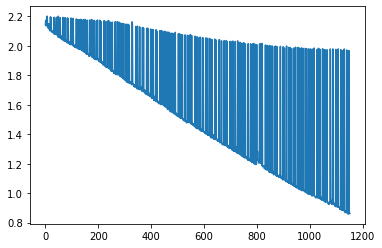

In [ ]:
## STOP HERE ##
import matplotlib.pyplot as plt
plt.plot(loss_list)


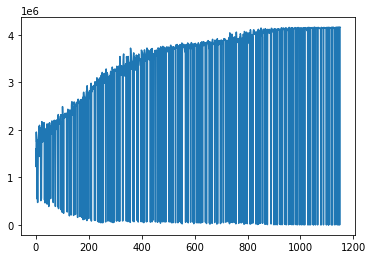

In [ ]:
plt.plot(acc_list)

image: (1, 256, 256, 64) label: torch.Size([256, 256, 64])
0.7720321140329416


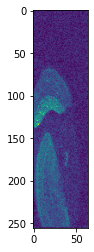

In [ ]:
#checking images manually
import random
def random_noise(image, noise_percent=0.2,  p=0.5):
    if randint(1,100) < p*100:
        image = image+torch.rand(image.shape).to("cuda")*noise_percent
        return image
    else:
        return(image)

for i, (images, labels) in enumerate(train_loader):
    noise = torch.rand(images.shape).to("cuda")*0.5
    images = images.to("cuda")
    
    #plt.imshow((images + noise).cpu()[0,0,10,:,:])
    noisy_img = random_noise(images, noise_percent=0.2, p=1)
    plt.imshow(noisy_img.cpu()[0,0,10,:,:])
    print(random.random())
    break

In [ ]:
model = torch.load('/content/drive/My Drive/BeeBrain_model.ckpt')

In [ ]:
# Test the model
with torch.no_grad(): # no gradient? what does it do?
    correct = 0
    total = 0
    for images, labels in test_loader: # can output 2 items like this out of test_loader output
              
        # labels are rotated by 90 degree 
        labels = torch.transpose(images,3,2)
        # labels are made binary by threshold 0.5
        labels = torch.where(labels>0.5,torch.tensor(1),torch.tensor(0)) # konvertiert bild zu binary
        # labels are flattened to have 1 value for each pixel to check if correct later
        labels = labels.flatten() # 100*changes to (100*28*28) -> (N) 
        # images to gpu
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.float)

        
        # images go through forward of model output: (2,28,28)
        print("labelvalues: ", labels)
        outputs = model(images)
        # swaps the dimensions so the 2 is at the end but the image dimensions are still right
        outputs = torch.transpose(outputs, 1,-1) # swaps the second with the last dimension
        outputs = torch.transpose(outputs,1,3)
        # needs another dimension swap for 3 dimensional
        outputs = torch.transpose(outputs, 1,2)
        # flattens to check corrected of all pixels with labels
        outputs = outputs.flatten(0,3)
        # takes the index of the max value of the outputs for each pixel -> means 0 or 1 for what is calculated 
        # to be more probably at the given pixel
        values, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item() # (predicted == labels) gibt eine reihe von true-false-true...
        # wieder. Weil True 1 ist und False 0, ist die summe genau die zahl der richtigen. Item gibt es als Int
        total += len(outputs)

    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

# Save the model and plot
#torch.save(model.state_dict(), MODEL_STORE_PATH + '_model.ckpt')


NameError: ignored

In [ ]:
### 1 Class at a time approach STARTS HERE !!! ###

In [1]:
from typing import Sequence, Optional

import torch


class CombinedLoss(torch.nn.Module):
    """Defines a loss function as a weighted sum of combinable loss criteria.
    Args:
        criteria: List of loss criterion modules that should be combined.
        weight: Weight assigned to the individual loss criteria (in the same
            order as ``criteria``).
        device: The device on which the loss should be computed. This needs
            to be set to the device that the loss arguments are allocated on.
    """

    def __init__(
            self,
            criteria: Sequence[torch.nn.Module],
            weight: Optional[Sequence[float]] = None,
            device: torch.device = None
    ):
        super().__init__()
        self.criteria = torch.nn.ModuleList(criteria)
        self.device = device
        if weight is None:
            weight = torch.ones(len(criteria))
        else:
            weight = torch.as_tensor(weight, dtype=torch.float32)
            assert weight.shape == (len(criteria),)
        self.register_buffer('weight', weight.to(self.device))

    def forward(self, *args):
        loss = torch.tensor(0., device=self.device)
        for crit, weight in zip(self.criteria, self.weight):
            crit = crit.to(self.device)
            loss += weight * crit(*args)
        return loss


def _channelwise_sum(x: torch.Tensor):
    """Sum-reduce all dimensions of a tensor except dimension 1 (C)"""
    reduce_dims = tuple([0] + list(range(x.dim()))[2:])  # = (0, 2, 3, ...)
    return x.sum(dim=reduce_dims)


def dice_loss(probs,
              target,
              weight=1.,
              eps=0.0001,
              ignore_index=False,
              no_reduction=False,
              ):
    # Probs need to be softmax probabilities, not raw network outputs
    tsh, psh = target.shape, probs.shape

    if tsh == psh:  # Already one-hot
        onehot_target = target.to(probs.dtype)
    elif tsh[0] == psh[0] and tsh[1:] == psh[2:]:  # Assume dense target storage, convert to one-hot
        onehot_target = torch.zeros_like(probs)
        onehot_target.scatter_(1, target.unsqueeze(1), 1)
    else:
        raise ValueError(
            f'Target shape {target.shape} is not compatible with output shape {probs.shape}.'
        )

    intersection = probs * onehot_target  # (N, C, ...)
    numerator = 2 * _channelwise_sum(intersection)  # (C,)
    denominator = probs + onehot_target  # (N, C, ...)
    denominator = _channelwise_sum(denominator) + eps  # (C,)
    loss_per_channel = 1 - (numerator / denominator)  # (C,)
    weighted_loss_per_channel = weight * loss_per_channel  # (C,)
    if ignore_index:
        weighted_loss_per_channel = weighted_loss_per_channel[1:]
        if no_reduction:
            return weighted_loss_per_channel
        else:
            return weighted_loss_per_channel.mean()
    else:
        if no_reduction:
            return weighted_loss_per_channel
        else:
            return weighted_loss_per_channel.mean()


class DiceLoss(torch.nn.Module):
    """Generalized Dice Loss, as described in https://arxiv.org/abs/1707.03237.
    Works for n-dimensional data. Assuming that the ``output`` tensor to be
    compared to the ``target`` has the shape (N, C, D, H, W), the ``target``
    can either have the same shape (N, C, D, H, W) (one-hot encoded) or
    (N, D, H, W) (with dense class indices, as in
    ``torch.nn.CrossEntropyLoss``). If the latter shape is detected, the
    ``target`` is automatically internally converted to a one-hot tensor
    for loss calculation.
    Args:
        apply_softmax: If ``True``, a softmax operation is applied to the
            ``output`` tensor before loss calculation. This is necessary if
            your model does not already apply softmax as the last layer.
            Use this if your model outputs 2 channels or more.
            If ``False``, ``output`` is assumed to already contain softmax
            probabilities.
        apply_sigmoid: If ``True``, a sigmoid operation is applied to the
            ``output`` tensor before loss calculation. This is necessary if
            your model does not already apply sigmoid as the last layer.
            Use this if your model ouputs only 1 channel.
            If ``False``, ``output`` is assumed to already contain sigmoid
            probabilities.
        weight: Weight tensor for class-wise loss rescaling.
            Has to be of shape (C,). If ``None``, classes are weighted equally.
    """

    def __init__(self,
                 apply_activation_function='softmax',
                 weight=torch.tensor(1.),
                 ignore_index=False,
                 no_reduction=False,
                 ):
        super().__init__()
        if apply_activation_function == 'softmax':
            self.layer = torch.nn.Softmax(dim=1)
        elif apply_activation_function == 'sigmoid':
            self.layer = torch.nn.Sigmoid()

        self.dice = dice_loss
        self.register_buffer('weight', weight)
        self.ignore_index = ignore_index
        self.no_reduction = no_reduction

    def forward(self, output, target):
        probs = self.layer(output)
        return self.dice(probs,
                         target,
                         weight=self.weight,
                         ignore_index=self.ignore_index,
                         no_reduction=self.no_reduction
                         )




In [2]:
## Transformation Functions -> outsource in Classfile later
from skimage.transform import rotate
from skimage import io
import matplotlib.pyplot as plt
from numpy import transpose
from random import randint, sample,seed, random
import numpy as np
from PIL import Image
#torchvision.transforms.RandomRotation(degrees, resample=False, expand=False, center=None, fill=None)
#torchvision.transforms.RandomHorizontalFlip(p=0.5)

# transformation with np.flip

def rotate3D(image, degreeX=0, degreeY=0, resize = True):
    stack = list()
    stack2 = list()
    if degreeX != 0:
        for i in image:
            i = Image.fromarray(np.uint16(i))
            i = i.rotate(degreeX)
            i = np.array(i)
            stack.append(i)
    else: stack = image

    if degreeY != 0:
        stack = transpose(stack)
        for i in stack: 
            i = Image.fromarray(np.uint16(i))
            i = i.rotate(degreeY)
            i = np.array(i)
            stack2.append(i)
        stack = transpose(stack2)
            
    else: stack2 = stack
    return stack2

def random_rotate3D_90(image,InnerSeed, p=0.5, resize = True):
    #seed(InnerSeed/2)
    if randint(1,100) < p*100:

        stack = list()
        stack2 = list()

        degreeX = sample((90,0,-90),1)[0]
        degreeY = sample((90,0,-90),1)[0]

        if degreeX != 0:
            for i in image:
                i = Image.fromarray(np.uint16(i))
                i = i.rotate(degreeX)
                i = np.array(i)
                stack.append(i)
        else: stack = image

        if degreeY != 0:
            stack = transpose(stack)
            for i in stack: 
                i = Image.fromarray(np.uint16(i))
                i = i.rotate(degreeY)
                i = np.array(i)
                stack2.append(i)
            stack = transpose(stack2)
                
        else: stack2 = stack
        return np.array(stack2)
    else:
        return(image)

def random_rotate3D_1830(image,InnerSeed, p=0.5, resize = True):
    seed(InnerSeed/3)
    print("seed: ", InnerSeed)
    print("random: ", randint(1,100))
    if randint(1,100) < p*100:

        stack = list()
        stack2 = list()

        degreeX = sample((180,0),1)[0]
        degreeY = sample((180,0),1)[0]

        if degreeX != 0:
            for i in image:
                i = Image.fromarray(np.uint16(i))
                i = i.rotate(degreeX)
                i = np.array(i)
                stack.append(i)
        else: stack = image

        if degreeY != 0:
            stack = transpose(stack)
            for i in stack: 
                i = Image.fromarray(np.uint16(i))
                i = i.rotate(degreeY)
                i = np.array(i)
                stack2.append(i)
            stack = transpose(stack2)
                
        else: stack2 = stack
        #print(np.array(stack2).shape)
        return np.array(stack2)
    else:
        #print(image.shape)
        return(image)


def random_rotate3D_flip(image,InnerSeed, p=0.5, resize = True):
    seed(InnerSeed/3)
    if randint(1,100) < p*100:


        degreeX = sample((180,0),1)[0]
        #print("X", degreeX)
        degreeY = sample((180,0),1)[0]
        #print("Y", degreeY)
        degreeZ = sample((180,0),1)[0]
        #print("Z", degreeZ)

        if degreeX != 0:
            image = np.flip(image, axis=-1)

        if degreeY != 0:
            image = np.flip(image, axis=-2)
                
        if degreeZ != 0:
            image = np.flip(image, axis=-3)
        return image
    else:
        return(image)

def random_rotate3D_transpose(image,InnerSeed, p=0.5, resize = True):
    seed(InnerSeed/2)
    if randint(1,100) < p*100:


        degreeX = sample((180,0),1)[0]
        #print("Xt", degreeX)
        degreeY = sample((180,0),1)[0]
        #print("Yt", degreeY)
        degreeZ = sample((180,0),1)[0]
        #print("Zt", degreeZ)

        if degreeX != 0:
            image = np.transpose(image, (0,2,1))

        if degreeY != 0:
            image = np.transpose(image, (1,0,2))
                
        if degreeZ != 0:
            image = np.transpose(image, (2,1,0))
        return image
    else:
        return(image)

def random_noise(image,  p=0.5):
    noise_intensity = random()/2
    if randint(1,100) < p*100:

        image = image+ torch.rand(image.shape)*noise_intensity
        return image
    else:
        return(image)



In [3]:
from collections import OrderedDict

import torch
import torch.nn as nn
from math import floor

class UNet(nn.Module):

    #def __init__(self, in_channels=1, out_channels=2, init_features=8): # für nur 2 classen variante
    def __init__(self, in_channels=1, out_channels=2, init_features=16):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2, ceil_mode=True)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.encoder5 = UNet._block(features * 8, features * 16, name="enc5")
        self.pool5 = nn.MaxPool3d(kernel_size=2, stride=2)
        #self.encoder6 = UNet._block(features * 16, features * 32, name="enc4")
        #self.pool6 = nn.MaxPool3d(kernel_size=2, stride=2)
        

        self.bottleneck = UNet._block(features * 16, features * 32, name="bottleneck")  

        #self.upconv6 = nn.ConvTranspose3d(
        #    features * 64, features * 32, kernel_size=2, stride=2                     
        #)
        #self.decoder6 = UNet._block((features * 32) * 2, features * 32, name="dec3") 
        self.upconv5 = nn.ConvTranspose3d(
            features * 32, features * 16, kernel_size=2, stride=2                     
        )
        self.decoder5 = UNet._block((features * 16) * 2, features * 16, name="dec5")
        self.upconv4 = nn.ConvTranspose3d(
            features * 16, features * 8, kernel_size=2, stride=2
        )                                                                                  
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")      
        self.upconv3 = nn.ConvTranspose3d(
            features * 8, features * 4, kernel_size=2, stride=2                     
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose3d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose3d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")
        

        self.conv = nn.Conv3d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

        self.dropout = nn.Dropout()


    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))
        enc5 = self.encoder5(self.pool4(enc4))
        #enc6 = self.encoder6(self.pool5(enc5))
      

        bottleneck = self.bottleneck(self.pool5(enc5))
        bottleneck = self.dropout(bottleneck)

        #dec6 = self.upconv6(bottleneck)
        #dec6 = torch.cat((dec6, enc6), dim=1)
        #dec6 = self.decoder6(dec6)

        dec5 = self.upconv5(bottleneck)
        dec5 = torch.cat((dec5,enc5), dim=1)
        dec5 = self.decoder5(dec5)

        dec4 = self.upconv4(dec5)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1) 
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return (self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv3d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm3d(num_features=features)),
                    (name + "relu1", nn.SELU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv3d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm3d(num_features=features)),
                    (name + "relu2", nn.SELU(inplace=True)),
                ]
            )
        )

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import torchvision.datasets

import numpy as np
from torch.utils.data import Dataset
import os
from skimage import io
from skimage.color import rgb2gray
from random import seed,randint



In [6]:

    #Initializing the Object for CNN
#model = UNet()
model = UNet()
#model = testNet()



if torch.cuda.is_available():
    device = torch.device("cuda") 
    torch.cuda.init()
else:
    device = torch.device("cpu")
#device = torch.device("cpu")
model.to(device)




class BeeDataset_2class(Dataset):

    def __init__(self, source_dir:str, transform, channel=0, labelclass=0):
        self.source_dir = source_dir
        self.data = []
        self.img = []
        self.transform = transform
        self.channel = channel
        # path to folder
        self.path = source_dir
        # takes all names in source folder and opens each image
        self.files = os.listdir(self.path+ "tiny_imagesTr/")
        self.labels = os.listdir(self.path+ "tiny_labelsTr/")
        self.labelclass = labelclass
    
    def __len__(self):
        # returns the length of the dataset/folder
        return len(self.files)

    def __getitem__(self,idx):
        seed()
        InnerSeed = randint(1,100000)
        ## better for biiiig datasets : loads the indexes data as soon as you ask for it (memory for speed)
        

        img = io.imread(self.path+"tiny_imagesTr/"+self.files[idx])
        label = io.imread(self.path+"tiny_labelsTr/new/"+self.files[idx].replace("tiny_", "new_tiny_label"))
        #label = np.int16(rgb2gray(label))
        #img = np.uint8(img) zu viel informationsverlust
        # Some Random Transforms
        #seed(InnerSeed)
        #img = random_rotate3D(img, InnerSeed = InnerSeed)
        #img = random_rotate3D_transpose(img, InnerSeed= InnerSeed)
        #img = random_rotate3D_flip(img, InnerSeed= InnerSeed)
        #img = np.flip(img,axis=-1)
        #seed(InnerSeed)
        #label = random_rotate3D(label, InnerSeed = InnerSeed)
        #label = random_rotate3D_transpose(label, InnerSeed= InnerSeed)
        #label = random_rotate3D_flip(label, InnerSeed= InnerSeed)
        #label = np.flip(label, axis = -1)
        img = self.transform(img)
        # adds 1 empty dimension
        img = random_noise(img, p=0.5)

        #img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
        img = np.expand_dims(img,0)


        # normalisation in transform pipeline not on labels
        #label = torch.tensor(label, dtype= torch.float)
        label = self.transform(label)
        


        ## In 2class variant: find out which class is background -> always use this as 0 and 1 as the class
        ## after converting to grayscale, takes unique values as classes
        
        ## convertion to 0-9 maybe not needed
        #unique = label.unique()
        #for i in range(0,len(unique)):
        #    label[label==unique[self.labelclass]] = 0
        #    label[label!=self.labelclass] = 1
        

        return img, label



# Hyperparameters
num_epochs = 500
#bei batchsize 2 will augmentation noch net
batch_size = 1
learning_rate = 0.0001


#train_data_path = "C:/Users/nicbr/BeeBrain/"
#train_data_path = "/home/nico/BeeBrain/"
train_data_path = "/content/drive/My Drive/BeeBrain/"
MODEL_STORE_PATH = '.'



# transforms to apply to the data
from sklearn.preprocessing import Normalizer
from skimage.transform import rotate
from numpy import transpose


def multi_dim_normalize(x):
    shape = x.shape
    return ((x.flatten() - x.min()) / x.max()).reshape(shape)

transformer = Normalizer()
img_transforms = transforms.Compose([#transforms.Lambda(lambda x: random_rotate3D(x, InnerSeed= InnerSeed)),
                                     #transforms.Lambda(lambda x: random_rotate3D_90(x, InnerSeed = InnerSeed)),
                                     #transforms.Lambda(lambda x: random_rotate3D_flip180(x, InnerSeed = InnerSeed)),
                                     transforms.Lambda(lambda x: multi_dim_normalize(x)),
                                     transforms.Lambda(lambda x: torch.tensor(x, dtype= torch.float)) # transforms.ToTensor doesnt work on that many dimensions
                                           ])

#def dice_loss(pred,target):
#    numerator = 2 * torch.sum(pred * target)
#    denominator = torch.sum(pred + target)
#    return 1 - (numerator + 1) / (denominator + 1)
    


Labelnumber [2], Epoch [1/500], Step [1/8], Loss: 71.5243,---------------------------------- Accuracy: 58.84%
Labelnumber [2], Epoch [1/500], Step [2/8], Loss: 73.0037,---------------------------------- Accuracy: 61.11%
Labelnumber [2], Epoch [1/500], Step [3/8], Loss: 70.8671,---------------------------------- Accuracy: 59.08%
Labelnumber [2], Epoch [1/500], Step [4/8], Loss: 81.7059,---------------------------------- Accuracy: 59.65%
Labelnumber [2], Epoch [1/500], Step [5/8], Loss: 79.6044,---------------------------------- Accuracy: 58.80%
Labelnumber [2], Epoch [1/500], Step [6/8], Loss: 70.7105,---------------------------------- Accuracy: 57.85%
Labelnumber [2], Epoch [1/500], Step [7/8], Loss: 67.5507,---------------------------------- Accuracy: 57.27%
Labelnumber [2], Epoch [1/500], Step [8/8], Loss: 77.5250,---------------------------------- Accuracy: 57.04%
Labelnumber [2], Epoch [2/500], Step [1/8], Loss: 80.3690,---------------------------------- Accuracy: 60.34%
Labelnumbe

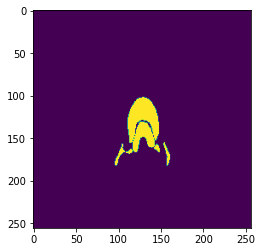

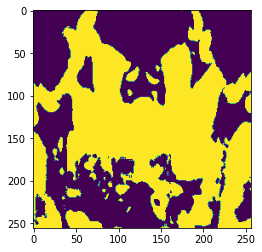

Labelnumber [2], Epoch [10/500], Step [3/8], Loss: 69.9326,---------------------------------- Accuracy: 70.78%
Labelnumber [2], Epoch [10/500], Step [4/8], Loss: 63.1910,---------------------------------- Accuracy: 74.21%
Labelnumber [2], Epoch [10/500], Step [5/8], Loss: 63.5953,---------------------------------- Accuracy: 75.67%
Labelnumber [2], Epoch [10/500], Step [6/8], Loss: 73.5725,---------------------------------- Accuracy: 77.34%
Labelnumber [2], Epoch [10/500], Step [7/8], Loss: 63.0871,---------------------------------- Accuracy: 76.38%
Labelnumber [2], Epoch [10/500], Step [8/8], Loss: 61.2244,---------------------------------- Accuracy: 75.99%
Labelnumber [2], Epoch [11/500], Step [1/8], Loss: 71.8302,---------------------------------- Accuracy: 76.42%
Labelnumber [2], Epoch [11/500], Step [2/8], Loss: 61.3705,---------------------------------- Accuracy: 77.24%
Labelnumber [2], Epoch [11/500], Step [3/8], Loss: 63.1622,---------------------------------- Accuracy: 79.35%
L

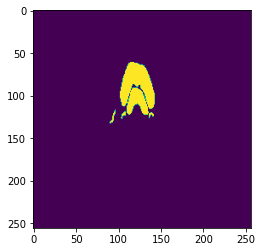

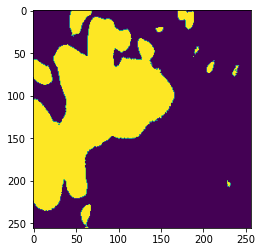

Labelnumber [2], Epoch [20/500], Step [3/8], Loss: 66.0950,---------------------------------- Accuracy: 84.38%
Labelnumber [2], Epoch [20/500], Step [4/8], Loss: 61.7845,---------------------------------- Accuracy: 84.99%
Labelnumber [2], Epoch [20/500], Step [5/8], Loss: 57.9213,---------------------------------- Accuracy: 84.39%
Labelnumber [2], Epoch [20/500], Step [6/8], Loss: 60.1493,---------------------------------- Accuracy: 84.11%
Labelnumber [2], Epoch [20/500], Step [7/8], Loss: 59.9905,---------------------------------- Accuracy: 84.37%
Labelnumber [2], Epoch [20/500], Step [8/8], Loss: 69.9713,---------------------------------- Accuracy: 86.01%
Labelnumber [2], Epoch [21/500], Step [1/8], Loss: 60.1649,---------------------------------- Accuracy: 87.93%
Labelnumber [2], Epoch [21/500], Step [2/8], Loss: 65.9926,---------------------------------- Accuracy: 85.39%
Labelnumber [2], Epoch [21/500], Step [3/8], Loss: 68.4235,---------------------------------- Accuracy: 84.07%
L

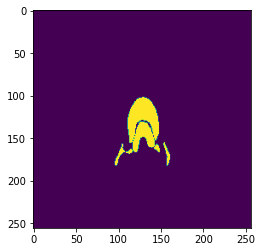

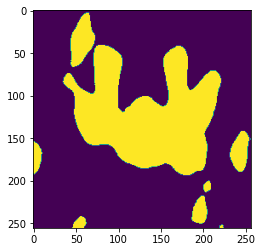

Labelnumber [2], Epoch [30/500], Step [3/8], Loss: 63.7977,---------------------------------- Accuracy: 87.33%
Labelnumber [2], Epoch [30/500], Step [4/8], Loss: 66.5716,---------------------------------- Accuracy: 88.03%
Labelnumber [2], Epoch [30/500], Step [5/8], Loss: 58.6505,---------------------------------- Accuracy: 88.70%
Labelnumber [2], Epoch [30/500], Step [6/8], Loss: 58.2905,---------------------------------- Accuracy: 89.19%
Labelnumber [2], Epoch [30/500], Step [7/8], Loss: 68.2411,---------------------------------- Accuracy: 89.07%
Labelnumber [2], Epoch [30/500], Step [8/8], Loss: 58.2396,---------------------------------- Accuracy: 89.39%
Labelnumber [2], Epoch [31/500], Step [1/8], Loss: 58.1301,---------------------------------- Accuracy: 87.99%
Labelnumber [2], Epoch [31/500], Step [2/8], Loss: 56.1053,---------------------------------- Accuracy: 87.59%
Labelnumber [2], Epoch [31/500], Step [3/8], Loss: 58.2280,---------------------------------- Accuracy: 88.38%
L

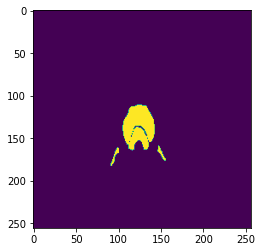

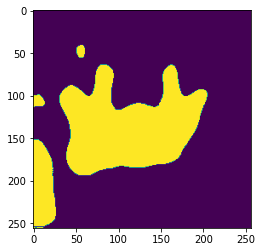

Labelnumber [2], Epoch [40/500], Step [3/8], Loss: 57.2775,---------------------------------- Accuracy: 90.84%
Labelnumber [2], Epoch [40/500], Step [4/8], Loss: 56.8874,---------------------------------- Accuracy: 90.45%
Labelnumber [2], Epoch [40/500], Step [5/8], Loss: 62.4214,---------------------------------- Accuracy: 89.35%
Labelnumber [2], Epoch [40/500], Step [6/8], Loss: 58.5284,---------------------------------- Accuracy: 88.62%
Labelnumber [2], Epoch [40/500], Step [7/8], Loss: 66.8391,---------------------------------- Accuracy: 88.88%
Labelnumber [2], Epoch [40/500], Step [8/8], Loss: 57.4005,---------------------------------- Accuracy: 89.69%
Labelnumber [2], Epoch [41/500], Step [1/8], Loss: 62.4176,---------------------------------- Accuracy: 91.29%
Labelnumber [2], Epoch [41/500], Step [2/8], Loss: 56.8498,---------------------------------- Accuracy: 91.58%
Labelnumber [2], Epoch [41/500], Step [3/8], Loss: 56.9150,---------------------------------- Accuracy: 90.63%
L

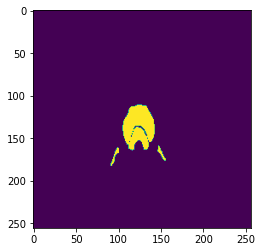

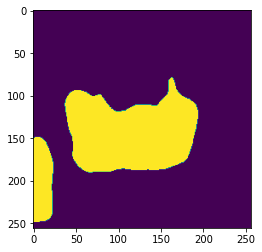

Labelnumber [2], Epoch [50/500], Step [3/8], Loss: 57.3190,---------------------------------- Accuracy: 92.14%
Labelnumber [2], Epoch [50/500], Step [4/8], Loss: 56.3258,---------------------------------- Accuracy: 92.11%
Labelnumber [2], Epoch [50/500], Step [5/8], Loss: 65.9747,---------------------------------- Accuracy: 91.15%
Labelnumber [2], Epoch [50/500], Step [6/8], Loss: 56.0224,---------------------------------- Accuracy: 89.66%
Labelnumber [2], Epoch [50/500], Step [7/8], Loss: 54.1031,---------------------------------- Accuracy: 89.61%
Labelnumber [2], Epoch [50/500], Step [8/8], Loss: 56.1052,---------------------------------- Accuracy: 90.73%
Labelnumber [2], Epoch [51/500], Step [1/8], Loss: 56.2117,---------------------------------- Accuracy: 91.35%
Labelnumber [2], Epoch [51/500], Step [2/8], Loss: 54.5191,---------------------------------- Accuracy: 93.14%
Labelnumber [2], Epoch [51/500], Step [3/8], Loss: 56.4410,---------------------------------- Accuracy: 90.24%
L

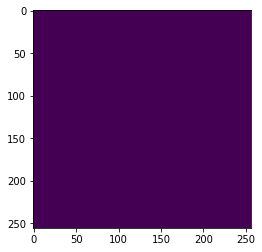

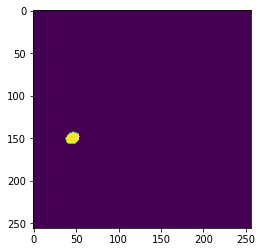

Labelnumber [2], Epoch [60/500], Step [3/8], Loss: 54.6288,---------------------------------- Accuracy: 92.46%
Labelnumber [2], Epoch [60/500], Step [4/8], Loss: 55.9779,---------------------------------- Accuracy: 92.32%
Labelnumber [2], Epoch [60/500], Step [5/8], Loss: 55.0037,---------------------------------- Accuracy: 92.20%
Labelnumber [2], Epoch [60/500], Step [6/8], Loss: 62.4360,---------------------------------- Accuracy: 92.02%
Labelnumber [2], Epoch [60/500], Step [7/8], Loss: 52.4705,---------------------------------- Accuracy: 92.29%
Labelnumber [2], Epoch [60/500], Step [8/8], Loss: 64.0642,---------------------------------- Accuracy: 92.36%
Labelnumber [2], Epoch [61/500], Step [1/8], Loss: 54.6155,---------------------------------- Accuracy: 92.48%
Labelnumber [2], Epoch [61/500], Step [2/8], Loss: 54.9768,---------------------------------- Accuracy: 92.66%
Labelnumber [2], Epoch [61/500], Step [3/8], Loss: 55.8491,---------------------------------- Accuracy: 92.29%
L

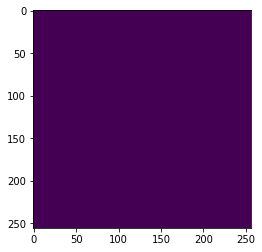

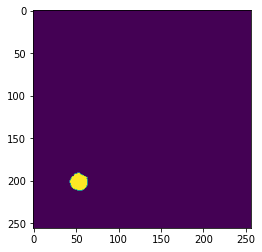

Labelnumber [2], Epoch [70/500], Step [3/8], Loss: 51.4858,---------------------------------- Accuracy: 92.61%
Labelnumber [2], Epoch [70/500], Step [4/8], Loss: 55.0308,---------------------------------- Accuracy: 93.10%
Labelnumber [2], Epoch [70/500], Step [5/8], Loss: 53.9228,---------------------------------- Accuracy: 93.44%
Labelnumber [2], Epoch [70/500], Step [6/8], Loss: 61.3110,---------------------------------- Accuracy: 93.34%
Labelnumber [2], Epoch [70/500], Step [7/8], Loss: 53.3893,---------------------------------- Accuracy: 93.15%
Labelnumber [2], Epoch [70/500], Step [8/8], Loss: 53.3890,---------------------------------- Accuracy: 92.89%
Labelnumber [2], Epoch [71/500], Step [1/8], Loss: 54.8180,---------------------------------- Accuracy: 92.67%
Labelnumber [2], Epoch [71/500], Step [2/8], Loss: 53.4832,---------------------------------- Accuracy: 93.22%
Labelnumber [2], Epoch [71/500], Step [3/8], Loss: 58.4861,---------------------------------- Accuracy: 93.48%
L

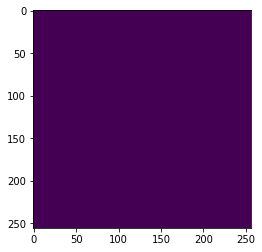

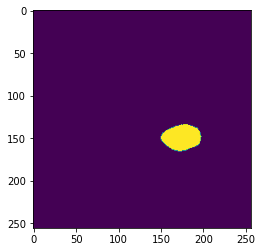

Labelnumber [2], Epoch [80/500], Step [3/8], Loss: 51.1016,---------------------------------- Accuracy: 93.59%
Labelnumber [2], Epoch [80/500], Step [4/8], Loss: 53.0611,---------------------------------- Accuracy: 93.09%
Labelnumber [2], Epoch [80/500], Step [5/8], Loss: 53.6993,---------------------------------- Accuracy: 92.50%
Labelnumber [2], Epoch [80/500], Step [6/8], Loss: 60.9041,---------------------------------- Accuracy: 92.60%
Labelnumber [2], Epoch [80/500], Step [7/8], Loss: 54.3128,---------------------------------- Accuracy: 93.23%
Labelnumber [2], Epoch [80/500], Step [8/8], Loss: 58.0798,---------------------------------- Accuracy: 93.32%
Labelnumber [2], Epoch [81/500], Step [1/8], Loss: 62.5441,---------------------------------- Accuracy: 93.77%
Labelnumber [2], Epoch [81/500], Step [2/8], Loss: 52.8401,---------------------------------- Accuracy: 93.26%
Labelnumber [2], Epoch [81/500], Step [3/8], Loss: 58.0185,---------------------------------- Accuracy: 93.48%
L

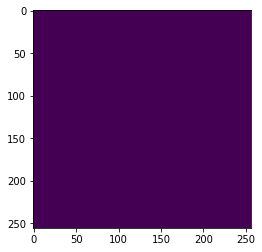

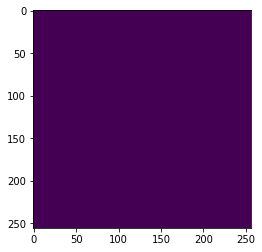

Labelnumber [2], Epoch [90/500], Step [3/8], Loss: 51.5261,---------------------------------- Accuracy: 94.41%
Labelnumber [2], Epoch [90/500], Step [4/8], Loss: 51.6490,---------------------------------- Accuracy: 94.03%
Labelnumber [2], Epoch [90/500], Step [5/8], Loss: 53.0654,---------------------------------- Accuracy: 93.95%
Labelnumber [2], Epoch [90/500], Step [6/8], Loss: 52.1193,---------------------------------- Accuracy: 93.91%
Labelnumber [2], Epoch [90/500], Step [7/8], Loss: 56.7056,---------------------------------- Accuracy: 94.36%
Labelnumber [2], Epoch [90/500], Step [8/8], Loss: 59.3823,---------------------------------- Accuracy: 93.97%
Labelnumber [2], Epoch [91/500], Step [1/8], Loss: 51.6061,---------------------------------- Accuracy: 93.94%
Labelnumber [2], Epoch [91/500], Step [2/8], Loss: 60.9205,---------------------------------- Accuracy: 93.89%
Labelnumber [2], Epoch [91/500], Step [3/8], Loss: 52.0892,---------------------------------- Accuracy: 93.89%
L

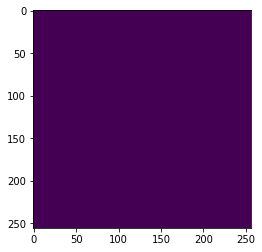

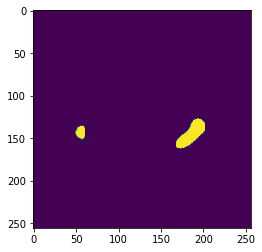

Labelnumber [2], Epoch [100/500], Step [3/8], Loss: 60.0931,---------------------------------- Accuracy: 94.52%
Labelnumber [2], Epoch [100/500], Step [4/8], Loss: 58.5701,---------------------------------- Accuracy: 93.74%
Labelnumber [2], Epoch [100/500], Step [5/8], Loss: 48.7298,---------------------------------- Accuracy: 94.67%
Labelnumber [2], Epoch [100/500], Step [6/8], Loss: 52.3114,---------------------------------- Accuracy: 94.17%
Labelnumber [2], Epoch [100/500], Step [7/8], Loss: 50.7268,---------------------------------- Accuracy: 94.31%
Labelnumber [2], Epoch [100/500], Step [8/8], Loss: 55.8481,---------------------------------- Accuracy: 95.01%
Labelnumber [2], Epoch [101/500], Step [1/8], Loss: 51.1312,---------------------------------- Accuracy: 94.78%
Labelnumber [2], Epoch [101/500], Step [2/8], Loss: 59.8315,---------------------------------- Accuracy: 94.91%
Labelnumber [2], Epoch [101/500], Step [3/8], Loss: 50.5925,---------------------------------- Accuracy:

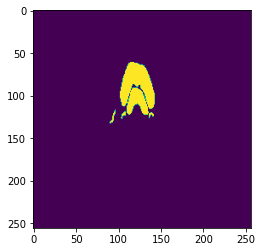

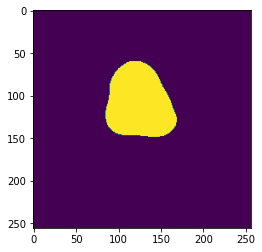

Labelnumber [2], Epoch [110/500], Step [3/8], Loss: 49.4184,---------------------------------- Accuracy: 95.62%
Labelnumber [2], Epoch [110/500], Step [4/8], Loss: 50.7539,---------------------------------- Accuracy: 95.53%
Labelnumber [2], Epoch [110/500], Step [5/8], Loss: 57.0336,---------------------------------- Accuracy: 95.57%
Labelnumber [2], Epoch [110/500], Step [6/8], Loss: 54.3397,---------------------------------- Accuracy: 95.90%
Labelnumber [2], Epoch [110/500], Step [7/8], Loss: 47.6750,---------------------------------- Accuracy: 95.44%
Labelnumber [2], Epoch [110/500], Step [8/8], Loss: 49.2702,---------------------------------- Accuracy: 95.12%
Labelnumber [2], Epoch [111/500], Step [1/8], Loss: 49.5156,---------------------------------- Accuracy: 94.86%
Labelnumber [2], Epoch [111/500], Step [2/8], Loss: 49.2765,---------------------------------- Accuracy: 95.21%
Labelnumber [2], Epoch [111/500], Step [3/8], Loss: 47.4008,---------------------------------- Accuracy:

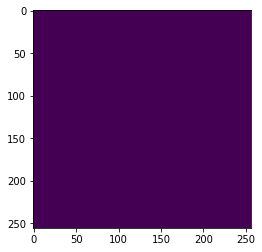

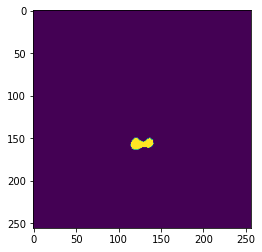

Labelnumber [2], Epoch [120/500], Step [3/8], Loss: 49.4275,---------------------------------- Accuracy: 96.05%
Labelnumber [2], Epoch [120/500], Step [4/8], Loss: 53.1078,---------------------------------- Accuracy: 96.34%
Labelnumber [2], Epoch [120/500], Step [5/8], Loss: 47.9077,---------------------------------- Accuracy: 96.06%
Labelnumber [2], Epoch [120/500], Step [6/8], Loss: 48.5561,---------------------------------- Accuracy: 95.93%
Labelnumber [2], Epoch [120/500], Step [7/8], Loss: 46.0720,---------------------------------- Accuracy: 95.85%
Labelnumber [2], Epoch [120/500], Step [8/8], Loss: 48.1167,---------------------------------- Accuracy: 95.79%
Labelnumber [2], Epoch [121/500], Step [1/8], Loss: 48.4839,---------------------------------- Accuracy: 95.80%
Labelnumber [2], Epoch [121/500], Step [2/8], Loss: 48.1245,---------------------------------- Accuracy: 96.04%
Labelnumber [2], Epoch [121/500], Step [3/8], Loss: 46.0790,---------------------------------- Accuracy:

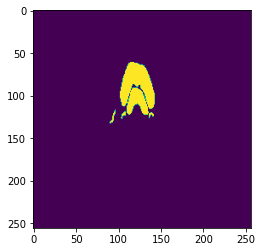

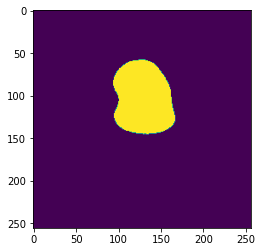

Labelnumber [2], Epoch [130/500], Step [3/8], Loss: 48.4075,---------------------------------- Accuracy: 94.92%
Labelnumber [2], Epoch [130/500], Step [4/8], Loss: 47.9455,---------------------------------- Accuracy: 95.50%
Labelnumber [2], Epoch [130/500], Step [5/8], Loss: 53.0612,---------------------------------- Accuracy: 95.02%
Labelnumber [2], Epoch [130/500], Step [6/8], Loss: 56.8938,---------------------------------- Accuracy: 95.67%
Labelnumber [2], Epoch [130/500], Step [7/8], Loss: 55.2183,---------------------------------- Accuracy: 96.23%
Labelnumber [2], Epoch [130/500], Step [8/8], Loss: 48.7409,---------------------------------- Accuracy: 96.53%
Labelnumber [2], Epoch [131/500], Step [1/8], Loss: 48.8478,---------------------------------- Accuracy: 96.22%
Labelnumber [2], Epoch [131/500], Step [2/8], Loss: 47.2749,---------------------------------- Accuracy: 96.17%
Labelnumber [2], Epoch [131/500], Step [3/8], Loss: 54.9025,---------------------------------- Accuracy:

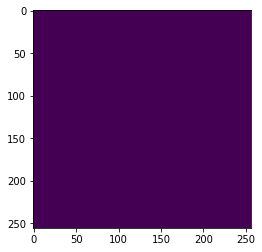

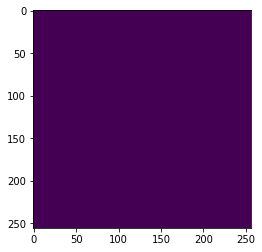

Labelnumber [2], Epoch [140/500], Step [3/8], Loss: 45.2689,---------------------------------- Accuracy: 96.98%
Labelnumber [2], Epoch [140/500], Step [4/8], Loss: 54.2985,---------------------------------- Accuracy: 96.86%
Labelnumber [2], Epoch [140/500], Step [5/8], Loss: 52.7240,---------------------------------- Accuracy: 97.02%
Labelnumber [2], Epoch [140/500], Step [6/8], Loss: 50.1622,---------------------------------- Accuracy: 97.14%
Labelnumber [2], Epoch [140/500], Step [7/8], Loss: 45.8762,---------------------------------- Accuracy: 97.17%
Labelnumber [2], Epoch [140/500], Step [8/8], Loss: 45.3674,---------------------------------- Accuracy: 97.18%
Labelnumber [2], Epoch [141/500], Step [1/8], Loss: 46.5581,---------------------------------- Accuracy: 97.03%
Labelnumber [2], Epoch [141/500], Step [2/8], Loss: 45.2696,---------------------------------- Accuracy: 97.10%
Labelnumber [2], Epoch [141/500], Step [3/8], Loss: 50.0310,---------------------------------- Accuracy:

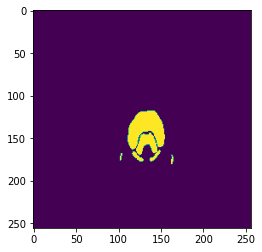

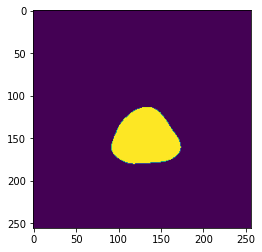

Labelnumber [2], Epoch [150/500], Step [3/8], Loss: 44.2842,---------------------------------- Accuracy: 97.46%
Labelnumber [2], Epoch [150/500], Step [4/8], Loss: 53.0874,---------------------------------- Accuracy: 97.77%
Labelnumber [2], Epoch [150/500], Step [5/8], Loss: 51.2443,---------------------------------- Accuracy: 97.30%
Labelnumber [2], Epoch [150/500], Step [6/8], Loss: 44.5259,---------------------------------- Accuracy: 97.34%
Labelnumber [2], Epoch [150/500], Step [7/8], Loss: 42.7239,---------------------------------- Accuracy: 97.28%
Labelnumber [2], Epoch [150/500], Step [8/8], Loss: 43.9693,---------------------------------- Accuracy: 97.16%
Labelnumber [2], Epoch [151/500], Step [1/8], Loss: 42.1959,---------------------------------- Accuracy: 97.09%
Labelnumber [2], Epoch [151/500], Step [2/8], Loss: 45.6980,---------------------------------- Accuracy: 97.39%
Labelnumber [2], Epoch [151/500], Step [3/8], Loss: 43.9096,---------------------------------- Accuracy:

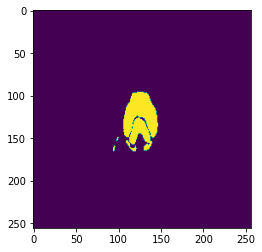

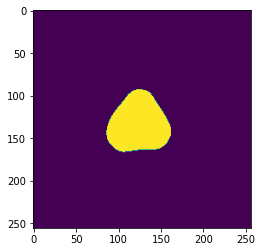

Labelnumber [2], Epoch [160/500], Step [3/8], Loss: 50.5943,---------------------------------- Accuracy: 97.89%
Labelnumber [2], Epoch [160/500], Step [4/8], Loss: 49.0927,---------------------------------- Accuracy: 97.96%
Labelnumber [2], Epoch [160/500], Step [5/8], Loss: 43.1388,---------------------------------- Accuracy: 97.93%
Labelnumber [2], Epoch [160/500], Step [6/8], Loss: 42.2686,---------------------------------- Accuracy: 97.97%
Labelnumber [2], Epoch [160/500], Step [7/8], Loss: 46.4752,---------------------------------- Accuracy: 97.99%
Labelnumber [2], Epoch [160/500], Step [8/8], Loss: 41.8255,---------------------------------- Accuracy: 98.00%
Labelnumber [2], Epoch [161/500], Step [1/8], Loss: 48.9141,---------------------------------- Accuracy: 97.89%
Labelnumber [2], Epoch [161/500], Step [2/8], Loss: 42.9740,---------------------------------- Accuracy: 97.82%
Labelnumber [2], Epoch [161/500], Step [3/8], Loss: 41.5253,---------------------------------- Accuracy:

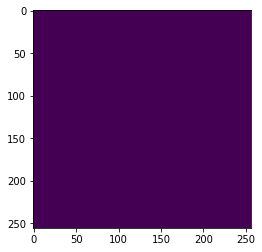

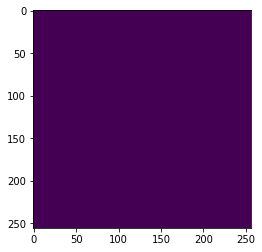

Labelnumber [2], Epoch [170/500], Step [3/8], Loss: 48.3975,---------------------------------- Accuracy: 97.76%
Labelnumber [2], Epoch [170/500], Step [4/8], Loss: 40.7301,---------------------------------- Accuracy: 97.62%
Labelnumber [2], Epoch [170/500], Step [5/8], Loss: 39.1571,---------------------------------- Accuracy: 97.78%
Labelnumber [2], Epoch [170/500], Step [6/8], Loss: 42.0044,---------------------------------- Accuracy: 97.68%
Labelnumber [2], Epoch [170/500], Step [7/8], Loss: 49.3480,---------------------------------- Accuracy: 97.82%
Labelnumber [2], Epoch [170/500], Step [8/8], Loss: 41.5570,---------------------------------- Accuracy: 97.90%
Labelnumber [2], Epoch [171/500], Step [1/8], Loss: 40.8530,---------------------------------- Accuracy: 97.90%
Labelnumber [2], Epoch [171/500], Step [2/8], Loss: 45.4682,---------------------------------- Accuracy: 97.88%
Labelnumber [2], Epoch [171/500], Step [3/8], Loss: 40.4812,---------------------------------- Accuracy:

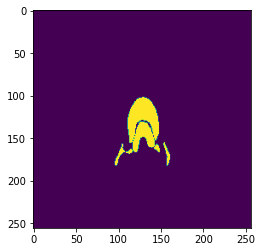

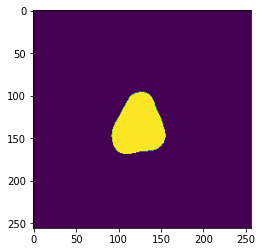

Labelnumber [2], Epoch [180/500], Step [3/8], Loss: 39.8890,---------------------------------- Accuracy: 98.02%
Labelnumber [2], Epoch [180/500], Step [4/8], Loss: 47.6588,---------------------------------- Accuracy: 98.03%
Labelnumber [2], Epoch [180/500], Step [5/8], Loss: 48.3892,---------------------------------- Accuracy: 98.00%
Labelnumber [2], Epoch [180/500], Step [6/8], Loss: 39.6706,---------------------------------- Accuracy: 97.87%
Labelnumber [2], Epoch [180/500], Step [7/8], Loss: 37.6110,---------------------------------- Accuracy: 97.92%
Labelnumber [2], Epoch [180/500], Step [8/8], Loss: 43.8319,---------------------------------- Accuracy: 98.06%
Labelnumber [2], Epoch [181/500], Step [1/8], Loss: 46.4232,---------------------------------- Accuracy: 97.98%
Labelnumber [2], Epoch [181/500], Step [2/8], Loss: 39.1747,---------------------------------- Accuracy: 98.07%
Labelnumber [2], Epoch [181/500], Step [3/8], Loss: 39.5152,---------------------------------- Accuracy:

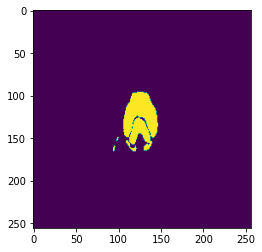

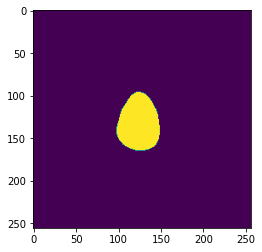

Labelnumber [2], Epoch [190/500], Step [3/8], Loss: 37.4839,---------------------------------- Accuracy: 98.54%
Labelnumber [2], Epoch [190/500], Step [4/8], Loss: 34.7728,---------------------------------- Accuracy: 98.62%
Labelnumber [2], Epoch [190/500], Step [5/8], Loss: 44.3416,---------------------------------- Accuracy: 98.55%
Labelnumber [2], Epoch [190/500], Step [6/8], Loss: 40.7295,---------------------------------- Accuracy: 98.71%
Labelnumber [2], Epoch [190/500], Step [7/8], Loss: 36.5440,---------------------------------- Accuracy: 98.77%
Labelnumber [2], Epoch [190/500], Step [8/8], Loss: 42.7503,---------------------------------- Accuracy: 98.76%
Labelnumber [2], Epoch [191/500], Step [1/8], Loss: 44.1503,---------------------------------- Accuracy: 98.84%
Labelnumber [2], Epoch [191/500], Step [2/8], Loss: 42.3757,---------------------------------- Accuracy: 98.83%
Labelnumber [2], Epoch [191/500], Step [3/8], Loss: 35.7305,---------------------------------- Accuracy:

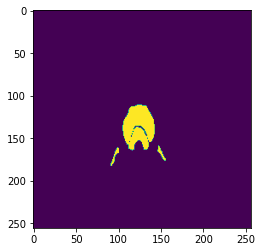

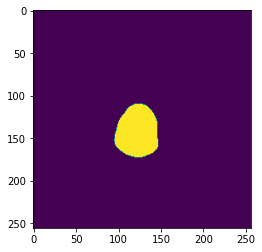

Labelnumber [2], Epoch [200/500], Step [3/8], Loss: 34.1061,---------------------------------- Accuracy: 98.81%
Labelnumber [2], Epoch [200/500], Step [4/8], Loss: 32.0033,---------------------------------- Accuracy: 98.81%
Labelnumber [2], Epoch [200/500], Step [5/8], Loss: 33.6331,---------------------------------- Accuracy: 98.79%
Labelnumber [2], Epoch [200/500], Step [6/8], Loss: 35.1973,---------------------------------- Accuracy: 98.80%
Labelnumber [2], Epoch [200/500], Step [7/8], Loss: 34.2176,---------------------------------- Accuracy: 98.90%
Labelnumber [2], Epoch [200/500], Step [8/8], Loss: 41.6242,---------------------------------- Accuracy: 98.87%
Labelnumber [2], Epoch [201/500], Step [1/8], Loss: 34.5264,---------------------------------- Accuracy: 98.95%
Labelnumber [2], Epoch [201/500], Step [2/8], Loss: 41.5261,---------------------------------- Accuracy: 99.01%
Labelnumber [2], Epoch [201/500], Step [3/8], Loss: 39.9724,---------------------------------- Accuracy:

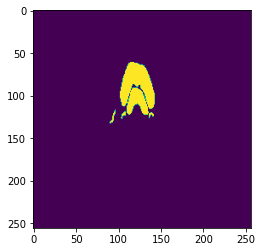

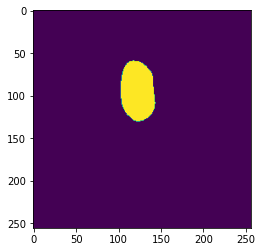

Labelnumber [2], Epoch [210/500], Step [3/8], Loss: 32.5147,---------------------------------- Accuracy: 99.20%
Labelnumber [2], Epoch [210/500], Step [4/8], Loss: 34.0147,---------------------------------- Accuracy: 99.23%
Labelnumber [2], Epoch [210/500], Step [5/8], Loss: 31.2325,---------------------------------- Accuracy: 99.28%
Labelnumber [2], Epoch [210/500], Step [6/8], Loss: 38.2743,---------------------------------- Accuracy: 99.21%
Labelnumber [2], Epoch [210/500], Step [7/8], Loss: 28.7972,---------------------------------- Accuracy: 99.31%
Labelnumber [2], Epoch [210/500], Step [8/8], Loss: 37.0505,---------------------------------- Accuracy: 99.24%
Labelnumber [2], Epoch [211/500], Step [1/8], Loss: 30.9271,---------------------------------- Accuracy: 99.21%
Labelnumber [2], Epoch [211/500], Step [2/8], Loss: 30.9289,---------------------------------- Accuracy: 99.27%
Labelnumber [2], Epoch [211/500], Step [3/8], Loss: 29.6149,---------------------------------- Accuracy:

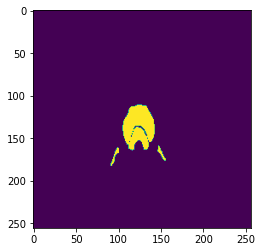

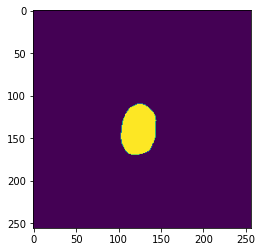

Labelnumber [2], Epoch [220/500], Step [3/8], Loss: 26.6327,---------------------------------- Accuracy: 99.53%
Labelnumber [2], Epoch [220/500], Step [4/8], Loss: 25.7401,---------------------------------- Accuracy: 99.42%
Labelnumber [2], Epoch [220/500], Step [5/8], Loss: 27.5713,---------------------------------- Accuracy: 99.35%
Labelnumber [2], Epoch [220/500], Step [6/8], Loss: 30.9469,---------------------------------- Accuracy: 99.34%
Labelnumber [2], Epoch [220/500], Step [7/8], Loss: 26.3587,---------------------------------- Accuracy: 99.42%
Labelnumber [2], Epoch [220/500], Step [8/8], Loss: 33.2328,---------------------------------- Accuracy: 99.44%
Labelnumber [2], Epoch [221/500], Step [1/8], Loss: 27.3046,---------------------------------- Accuracy: 99.52%
Labelnumber [2], Epoch [221/500], Step [2/8], Loss: 25.8179,---------------------------------- Accuracy: 99.58%
Labelnumber [2], Epoch [221/500], Step [3/8], Loss: 29.8332,---------------------------------- Accuracy:

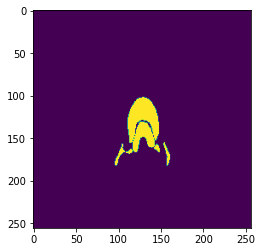

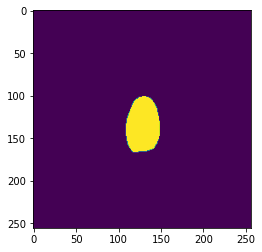

Labelnumber [2], Epoch [230/500], Step [3/8], Loss: 28.6808,---------------------------------- Accuracy: 99.55%
Labelnumber [2], Epoch [230/500], Step [4/8], Loss: 23.5125,---------------------------------- Accuracy: 99.55%
Labelnumber [2], Epoch [230/500], Step [5/8], Loss: 22.0780,---------------------------------- Accuracy: 99.54%
Labelnumber [2], Epoch [230/500], Step [6/8], Loss: 30.2259,---------------------------------- Accuracy: 99.51%
Labelnumber [2], Epoch [230/500], Step [7/8], Loss: 26.6873,---------------------------------- Accuracy: 99.52%
Labelnumber [2], Epoch [230/500], Step [8/8], Loss: 23.1863,---------------------------------- Accuracy: 99.54%
Labelnumber [2], Epoch [231/500], Step [1/8], Loss: 28.0405,---------------------------------- Accuracy: 99.54%
Labelnumber [2], Epoch [231/500], Step [2/8], Loss: 22.7548,---------------------------------- Accuracy: 99.60%
Labelnumber [2], Epoch [231/500], Step [3/8], Loss: 23.3031,---------------------------------- Accuracy:

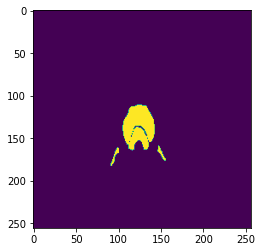

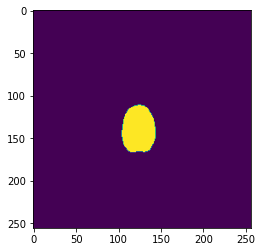

Labelnumber [2], Epoch [240/500], Step [3/8], Loss: 20.8880,---------------------------------- Accuracy: 99.67%
Labelnumber [2], Epoch [240/500], Step [4/8], Loss: 18.8397,---------------------------------- Accuracy: 99.65%
Labelnumber [2], Epoch [240/500], Step [5/8], Loss: 19.6464,---------------------------------- Accuracy: 99.68%
Labelnumber [2], Epoch [240/500], Step [6/8], Loss: 27.1639,---------------------------------- Accuracy: 99.58%
Labelnumber [2], Epoch [240/500], Step [7/8], Loss: 22.8278,---------------------------------- Accuracy: 99.66%
Labelnumber [2], Epoch [240/500], Step [8/8], Loss: 19.2423,---------------------------------- Accuracy: 99.67%
Labelnumber [2], Epoch [241/500], Step [1/8], Loss: 19.4239,---------------------------------- Accuracy: 99.67%
Labelnumber [2], Epoch [241/500], Step [2/8], Loss: 18.4701,---------------------------------- Accuracy: 99.69%
Labelnumber [2], Epoch [241/500], Step [3/8], Loss: 26.1491,---------------------------------- Accuracy:

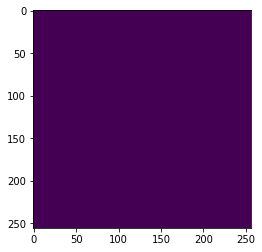

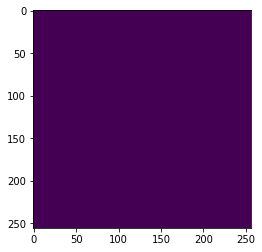

Labelnumber [2], Epoch [250/500], Step [3/8], Loss: 20.3789,---------------------------------- Accuracy: 99.69%
Labelnumber [2], Epoch [250/500], Step [4/8], Loss: 18.3722,---------------------------------- Accuracy: 99.64%
Labelnumber [2], Epoch [250/500], Step [5/8], Loss: 17.9320,---------------------------------- Accuracy: 99.69%
Labelnumber [2], Epoch [250/500], Step [6/8], Loss: 22.5747,---------------------------------- Accuracy: 99.67%
Labelnumber [2], Epoch [250/500], Step [7/8], Loss: 17.0132,---------------------------------- Accuracy: 99.75%
Labelnumber [2], Epoch [250/500], Step [8/8], Loss: 20.9545,---------------------------------- Accuracy: 99.76%
Labelnumber [2], Epoch [251/500], Step [1/8], Loss: 17.2160,---------------------------------- Accuracy: 99.74%
Labelnumber [2], Epoch [251/500], Step [2/8], Loss: 19.6340,---------------------------------- Accuracy: 99.74%
Labelnumber [2], Epoch [251/500], Step [3/8], Loss: 18.1440,---------------------------------- Accuracy:

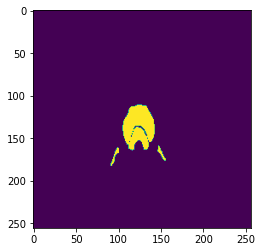

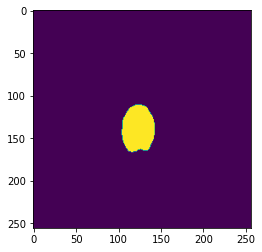

Labelnumber [2], Epoch [260/500], Step [3/8], Loss: 14.9595,---------------------------------- Accuracy: 99.77%
Labelnumber [2], Epoch [260/500], Step [4/8], Loss: 20.5600,---------------------------------- Accuracy: 99.70%
Labelnumber [2], Epoch [260/500], Step [5/8], Loss: 14.3686,---------------------------------- Accuracy: 99.75%
Labelnumber [2], Epoch [260/500], Step [6/8], Loss: 16.1791,---------------------------------- Accuracy: 99.72%
Labelnumber [2], Epoch [260/500], Step [7/8], Loss: 15.5429,---------------------------------- Accuracy: 99.73%
Labelnumber [2], Epoch [260/500], Step [8/8], Loss: 16.8192,---------------------------------- Accuracy: 99.65%
Labelnumber [2], Epoch [261/500], Step [1/8], Loss: 21.2542,---------------------------------- Accuracy: 99.60%
Labelnumber [2], Epoch [261/500], Step [2/8], Loss: 16.1612,---------------------------------- Accuracy: 99.65%
Labelnumber [2], Epoch [261/500], Step [3/8], Loss: 16.1002,---------------------------------- Accuracy:

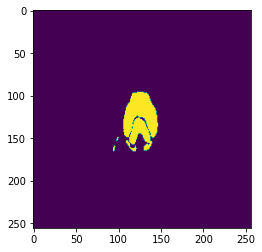

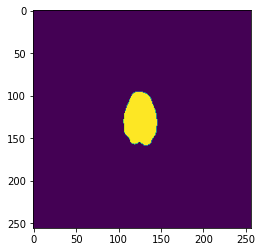

Labelnumber [2], Epoch [270/500], Step [3/8], Loss: 12.3925,---------------------------------- Accuracy: 99.77%
Labelnumber [2], Epoch [270/500], Step [4/8], Loss: 14.0274,---------------------------------- Accuracy: 99.76%
Labelnumber [2], Epoch [270/500], Step [5/8], Loss: 14.9034,---------------------------------- Accuracy: 99.79%
Labelnumber [2], Epoch [270/500], Step [6/8], Loss: 17.9648,---------------------------------- Accuracy: 99.75%
Labelnumber [2], Epoch [270/500], Step [7/8], Loss: 13.6592,---------------------------------- Accuracy: 99.75%
Labelnumber [2], Epoch [270/500], Step [8/8], Loss: 13.5353,---------------------------------- Accuracy: 99.75%
Labelnumber [2], Epoch [271/500], Step [1/8], Loss: 16.3946,---------------------------------- Accuracy: 99.78%
Labelnumber [2], Epoch [271/500], Step [2/8], Loss: 17.7658,---------------------------------- Accuracy: 99.76%
Labelnumber [2], Epoch [271/500], Step [3/8], Loss: 13.9827,---------------------------------- Accuracy:

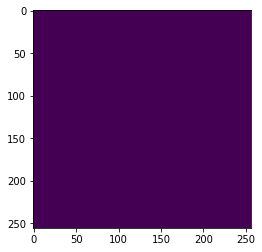

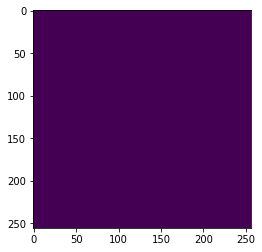

Labelnumber [2], Epoch [280/500], Step [3/8], Loss: 15.4985,---------------------------------- Accuracy: 99.77%
Labelnumber [2], Epoch [280/500], Step [4/8], Loss: 16.6835,---------------------------------- Accuracy: 99.73%
Labelnumber [2], Epoch [280/500], Step [5/8], Loss: 12.5677,---------------------------------- Accuracy: 99.75%
Labelnumber [2], Epoch [280/500], Step [6/8], Loss: 12.2660,---------------------------------- Accuracy: 99.80%
Labelnumber [2], Epoch [280/500], Step [7/8], Loss: 11.6207,---------------------------------- Accuracy: 99.79%
Labelnumber [2], Epoch [280/500], Step [8/8], Loss: 13.3563,---------------------------------- Accuracy: 99.83%
Labelnumber [2], Epoch [281/500], Step [1/8], Loss: 15.0788,---------------------------------- Accuracy: 99.79%
Labelnumber [2], Epoch [281/500], Step [2/8], Loss: 12.3490,---------------------------------- Accuracy: 99.78%
Labelnumber [2], Epoch [281/500], Step [3/8], Loss: 13.8809,---------------------------------- Accuracy:

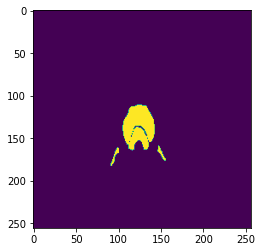

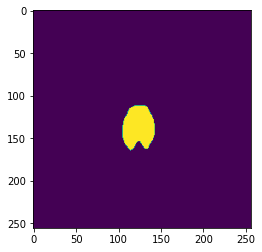

Labelnumber [2], Epoch [290/500], Step [3/8], Loss: 10.5551,---------------------------------- Accuracy: 99.82%
Labelnumber [2], Epoch [290/500], Step [4/8], Loss: 14.2627,---------------------------------- Accuracy: 99.82%
Labelnumber [2], Epoch [290/500], Step [5/8], Loss: 10.2102,---------------------------------- Accuracy: 99.83%
Labelnumber [2], Epoch [290/500], Step [6/8], Loss: 11.6542,---------------------------------- Accuracy: 99.84%
Labelnumber [2], Epoch [290/500], Step [7/8], Loss: 9.8536,---------------------------------- Accuracy: 99.81%
Labelnumber [2], Epoch [290/500], Step [8/8], Loss: 10.0209,---------------------------------- Accuracy: 99.82%
Labelnumber [2], Epoch [291/500], Step [1/8], Loss: 10.0030,---------------------------------- Accuracy: 99.83%
Labelnumber [2], Epoch [291/500], Step [2/8], Loss: 10.9457,---------------------------------- Accuracy: 99.80%
Labelnumber [2], Epoch [291/500], Step [3/8], Loss: 11.8793,---------------------------------- Accuracy: 

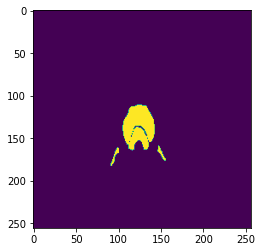

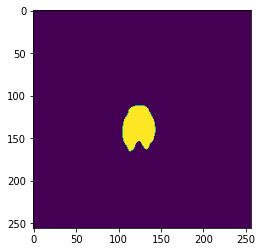

Labelnumber [2], Epoch [300/500], Step [3/8], Loss: 9.1035,---------------------------------- Accuracy: 99.84%
Labelnumber [2], Epoch [300/500], Step [4/8], Loss: 9.3210,---------------------------------- Accuracy: 99.81%
Labelnumber [2], Epoch [300/500], Step [5/8], Loss: 9.4455,---------------------------------- Accuracy: 99.82%
Labelnumber [2], Epoch [300/500], Step [6/8], Loss: 12.4916,---------------------------------- Accuracy: 99.82%
Labelnumber [2], Epoch [300/500], Step [7/8], Loss: 10.1649,---------------------------------- Accuracy: 99.80%
Labelnumber [2], Epoch [300/500], Step [8/8], Loss: 10.2601,---------------------------------- Accuracy: 99.82%
Labelnumber [2], Epoch [301/500], Step [1/8], Loss: 9.3433,---------------------------------- Accuracy: 99.81%
Labelnumber [2], Epoch [301/500], Step [2/8], Loss: 10.1870,---------------------------------- Accuracy: 99.82%
Labelnumber [2], Epoch [301/500], Step [3/8], Loss: 12.5348,---------------------------------- Accuracy: 99.

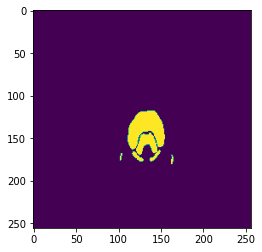

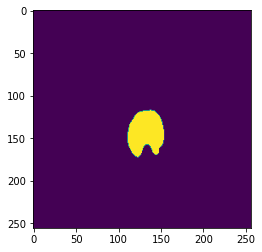

Labelnumber [2], Epoch [310/500], Step [3/8], Loss: 10.6949,---------------------------------- Accuracy: 99.79%
Labelnumber [2], Epoch [310/500], Step [4/8], Loss: 8.4118,---------------------------------- Accuracy: 99.85%
Labelnumber [2], Epoch [310/500], Step [5/8], Loss: 10.2861,---------------------------------- Accuracy: 99.86%
Labelnumber [2], Epoch [310/500], Step [6/8], Loss: 11.6268,---------------------------------- Accuracy: 99.84%
Labelnumber [2], Epoch [310/500], Step [7/8], Loss: 8.3472,---------------------------------- Accuracy: 99.85%
Labelnumber [2], Epoch [310/500], Step [8/8], Loss: 8.7465,---------------------------------- Accuracy: 99.83%
Labelnumber [2], Epoch [311/500], Step [1/8], Loss: 10.0157,---------------------------------- Accuracy: 99.84%
Labelnumber [2], Epoch [311/500], Step [2/8], Loss: 9.8922,---------------------------------- Accuracy: 99.79%
Labelnumber [2], Epoch [311/500], Step [3/8], Loss: 8.0794,---------------------------------- Accuracy: 99.8

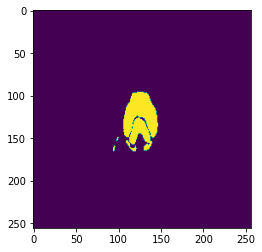

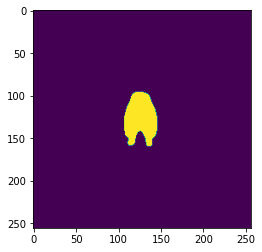

Labelnumber [2], Epoch [320/500], Step [3/8], Loss: 9.0585,---------------------------------- Accuracy: 99.82%
Labelnumber [2], Epoch [320/500], Step [4/8], Loss: 9.7391,---------------------------------- Accuracy: 99.86%
Labelnumber [2], Epoch [320/500], Step [5/8], Loss: 10.9365,---------------------------------- Accuracy: 99.85%
Labelnumber [2], Epoch [320/500], Step [6/8], Loss: 7.9110,---------------------------------- Accuracy: 99.82%
Labelnumber [2], Epoch [320/500], Step [7/8], Loss: 7.4947,---------------------------------- Accuracy: 99.86%
Labelnumber [2], Epoch [320/500], Step [8/8], Loss: 9.4134,---------------------------------- Accuracy: 99.84%
Labelnumber [2], Epoch [321/500], Step [1/8], Loss: 8.4855,---------------------------------- Accuracy: 99.82%
Labelnumber [2], Epoch [321/500], Step [2/8], Loss: 10.0335,---------------------------------- Accuracy: 99.79%
Labelnumber [2], Epoch [321/500], Step [3/8], Loss: 8.0546,---------------------------------- Accuracy: 99.83%

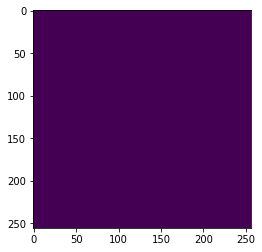

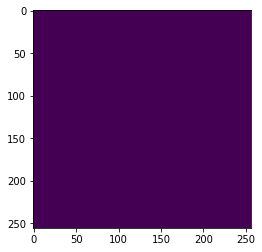

Labelnumber [2], Epoch [330/500], Step [3/8], Loss: 8.9640,---------------------------------- Accuracy: 99.86%
Labelnumber [2], Epoch [330/500], Step [4/8], Loss: 7.9871,---------------------------------- Accuracy: 99.84%
Labelnumber [2], Epoch [330/500], Step [5/8], Loss: 7.1570,---------------------------------- Accuracy: 99.86%
Labelnumber [2], Epoch [330/500], Step [6/8], Loss: 7.4992,---------------------------------- Accuracy: 99.84%
Labelnumber [2], Epoch [330/500], Step [7/8], Loss: 7.2182,---------------------------------- Accuracy: 99.86%
Labelnumber [2], Epoch [330/500], Step [8/8], Loss: 9.2551,---------------------------------- Accuracy: 99.86%
Labelnumber [2], Epoch [331/500], Step [1/8], Loss: 7.6129,---------------------------------- Accuracy: 99.84%
Labelnumber [2], Epoch [331/500], Step [2/8], Loss: 7.2412,---------------------------------- Accuracy: 99.83%
Labelnumber [2], Epoch [331/500], Step [3/8], Loss: 8.4330,---------------------------------- Accuracy: 99.83%
L

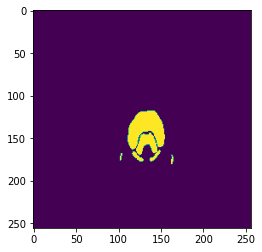

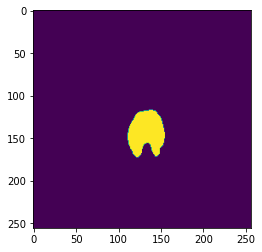

Labelnumber [2], Epoch [340/500], Step [3/8], Loss: 6.6016,---------------------------------- Accuracy: 99.87%
Labelnumber [2], Epoch [340/500], Step [4/8], Loss: 7.2499,---------------------------------- Accuracy: 99.82%
Labelnumber [2], Epoch [340/500], Step [5/8], Loss: 9.3033,---------------------------------- Accuracy: 99.84%
Labelnumber [2], Epoch [340/500], Step [6/8], Loss: 7.1738,---------------------------------- Accuracy: 99.85%
Labelnumber [2], Epoch [340/500], Step [7/8], Loss: 9.0667,---------------------------------- Accuracy: 99.87%
Labelnumber [2], Epoch [340/500], Step [8/8], Loss: 7.6858,---------------------------------- Accuracy: 99.84%
Labelnumber [2], Epoch [341/500], Step [1/8], Loss: 6.7583,---------------------------------- Accuracy: 99.87%
Labelnumber [2], Epoch [341/500], Step [2/8], Loss: 8.2346,---------------------------------- Accuracy: 99.88%
Labelnumber [2], Epoch [341/500], Step [3/8], Loss: 8.4496,---------------------------------- Accuracy: 99.82%
L

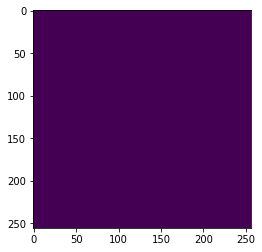

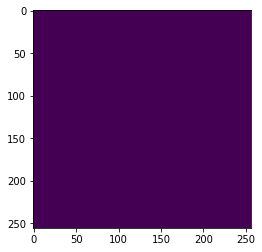

Labelnumber [2], Epoch [350/500], Step [3/8], Loss: 6.3992,---------------------------------- Accuracy: 99.86%
Labelnumber [2], Epoch [350/500], Step [4/8], Loss: 8.1138,---------------------------------- Accuracy: 99.85%
Labelnumber [2], Epoch [350/500], Step [5/8], Loss: 6.7878,---------------------------------- Accuracy: 99.85%
Labelnumber [2], Epoch [350/500], Step [6/8], Loss: 7.0678,---------------------------------- Accuracy: 99.85%
Labelnumber [2], Epoch [350/500], Step [7/8], Loss: 6.3506,---------------------------------- Accuracy: 99.87%
Labelnumber [2], Epoch [350/500], Step [8/8], Loss: 10.4651,---------------------------------- Accuracy: 99.83%
Labelnumber [2], Epoch [351/500], Step [1/8], Loss: 6.7235,---------------------------------- Accuracy: 99.87%
Labelnumber [2], Epoch [351/500], Step [2/8], Loss: 7.1293,---------------------------------- Accuracy: 99.82%
Labelnumber [2], Epoch [351/500], Step [3/8], Loss: 7.2549,---------------------------------- Accuracy: 99.84%


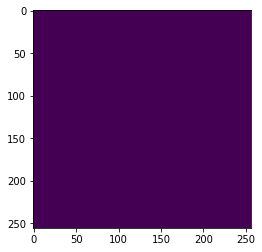

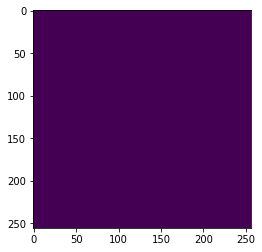

Labelnumber [2], Epoch [360/500], Step [3/8], Loss: 6.6102,---------------------------------- Accuracy: 99.85%
Labelnumber [2], Epoch [360/500], Step [4/8], Loss: 7.1347,---------------------------------- Accuracy: 99.84%
Labelnumber [2], Epoch [360/500], Step [5/8], Loss: 7.0151,---------------------------------- Accuracy: 99.84%
Labelnumber [2], Epoch [360/500], Step [6/8], Loss: 6.7178,---------------------------------- Accuracy: 99.82%
Labelnumber [2], Epoch [360/500], Step [7/8], Loss: 8.2965,---------------------------------- Accuracy: 99.86%
Labelnumber [2], Epoch [360/500], Step [8/8], Loss: 7.1460,---------------------------------- Accuracy: 99.87%
Labelnumber [2], Epoch [361/500], Step [1/8], Loss: 6.1715,---------------------------------- Accuracy: 99.87%
Labelnumber [2], Epoch [361/500], Step [2/8], Loss: 7.5024,---------------------------------- Accuracy: 99.88%
Labelnumber [2], Epoch [361/500], Step [3/8], Loss: 8.5311,---------------------------------- Accuracy: 99.80%
L

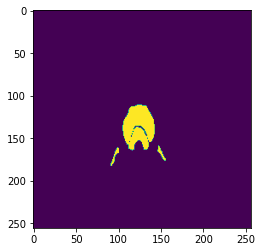

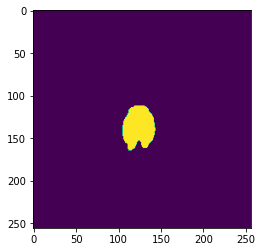

Labelnumber [2], Epoch [370/500], Step [3/8], Loss: 6.4901,---------------------------------- Accuracy: 99.85%
Labelnumber [2], Epoch [370/500], Step [4/8], Loss: 7.9452,---------------------------------- Accuracy: 99.87%
Labelnumber [2], Epoch [370/500], Step [5/8], Loss: 6.2773,---------------------------------- Accuracy: 99.86%
Labelnumber [2], Epoch [370/500], Step [6/8], Loss: 6.2637,---------------------------------- Accuracy: 99.86%
Labelnumber [2], Epoch [370/500], Step [7/8], Loss: 5.4756,---------------------------------- Accuracy: 99.88%
Labelnumber [2], Epoch [370/500], Step [8/8], Loss: 5.7872,---------------------------------- Accuracy: 99.86%
Labelnumber [2], Epoch [371/500], Step [1/8], Loss: 5.6693,---------------------------------- Accuracy: 99.86%
Labelnumber [2], Epoch [371/500], Step [2/8], Loss: 6.2316,---------------------------------- Accuracy: 99.85%
Labelnumber [2], Epoch [371/500], Step [3/8], Loss: 6.6569,---------------------------------- Accuracy: 99.88%
L

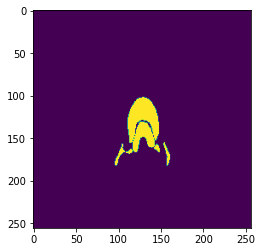

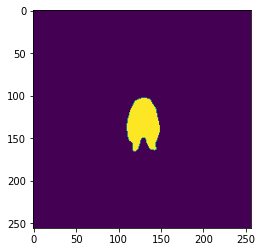

Labelnumber [2], Epoch [380/500], Step [3/8], Loss: 8.3245,---------------------------------- Accuracy: 99.85%
Labelnumber [2], Epoch [380/500], Step [4/8], Loss: 6.7998,---------------------------------- Accuracy: 99.89%
Labelnumber [2], Epoch [380/500], Step [5/8], Loss: 7.1618,---------------------------------- Accuracy: 99.86%
Labelnumber [2], Epoch [380/500], Step [6/8], Loss: 6.6561,---------------------------------- Accuracy: 99.84%
Labelnumber [2], Epoch [380/500], Step [7/8], Loss: 5.7047,---------------------------------- Accuracy: 99.86%
Labelnumber [2], Epoch [380/500], Step [8/8], Loss: 5.7214,---------------------------------- Accuracy: 99.87%
Labelnumber [2], Epoch [381/500], Step [1/8], Loss: 7.4925,---------------------------------- Accuracy: 99.81%
Labelnumber [2], Epoch [381/500], Step [2/8], Loss: 8.1206,---------------------------------- Accuracy: 99.85%
Labelnumber [2], Epoch [381/500], Step [3/8], Loss: 5.6122,---------------------------------- Accuracy: 99.87%
L

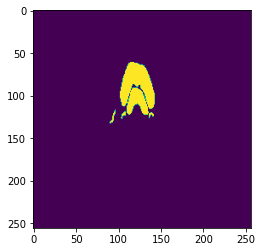

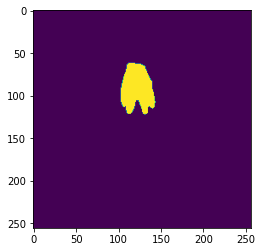

Labelnumber [2], Epoch [390/500], Step [3/8], Loss: 8.0848,---------------------------------- Accuracy: 99.85%
Labelnumber [2], Epoch [390/500], Step [4/8], Loss: 5.9784,---------------------------------- Accuracy: 99.89%
Labelnumber [2], Epoch [390/500], Step [5/8], Loss: 5.2419,---------------------------------- Accuracy: 99.88%
Labelnumber [2], Epoch [390/500], Step [6/8], Loss: 6.2972,---------------------------------- Accuracy: 99.85%
Labelnumber [2], Epoch [390/500], Step [7/8], Loss: 5.4237,---------------------------------- Accuracy: 99.86%
Labelnumber [2], Epoch [390/500], Step [8/8], Loss: 5.4865,---------------------------------- Accuracy: 99.87%
Labelnumber [2], Epoch [391/500], Step [1/8], Loss: 6.9341,---------------------------------- Accuracy: 99.88%
Labelnumber [2], Epoch [391/500], Step [2/8], Loss: 6.1792,---------------------------------- Accuracy: 99.85%
Labelnumber [2], Epoch [391/500], Step [3/8], Loss: 6.1905,---------------------------------- Accuracy: 99.88%
L

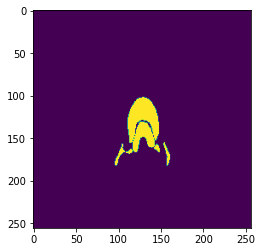

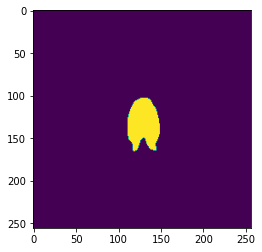

Labelnumber [2], Epoch [400/500], Step [3/8], Loss: 5.3601,---------------------------------- Accuracy: 99.87%
Labelnumber [2], Epoch [400/500], Step [4/8], Loss: 5.3833,---------------------------------- Accuracy: 99.86%
Labelnumber [2], Epoch [400/500], Step [5/8], Loss: 6.1268,---------------------------------- Accuracy: 99.89%
Labelnumber [2], Epoch [400/500], Step [6/8], Loss: 5.8714,---------------------------------- Accuracy: 99.88%
Labelnumber [2], Epoch [400/500], Step [7/8], Loss: 5.6818,---------------------------------- Accuracy: 99.86%
Labelnumber [2], Epoch [400/500], Step [8/8], Loss: 5.2865,---------------------------------- Accuracy: 99.87%
Labelnumber [2], Epoch [401/500], Step [1/8], Loss: 5.2006,---------------------------------- Accuracy: 99.86%
Labelnumber [2], Epoch [401/500], Step [2/8], Loss: 6.6026,---------------------------------- Accuracy: 99.89%
Labelnumber [2], Epoch [401/500], Step [3/8], Loss: 7.2814,---------------------------------- Accuracy: 99.86%
L

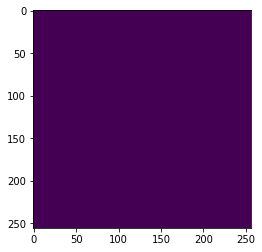

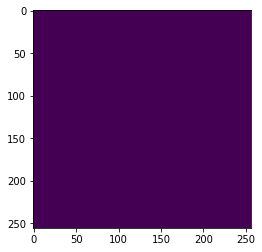

Labelnumber [2], Epoch [410/500], Step [3/8], Loss: 6.0039,---------------------------------- Accuracy: 99.85%
Labelnumber [2], Epoch [410/500], Step [4/8], Loss: 4.6420,---------------------------------- Accuracy: 99.88%
Labelnumber [2], Epoch [410/500], Step [5/8], Loss: 5.6586,---------------------------------- Accuracy: 99.89%
Labelnumber [2], Epoch [410/500], Step [6/8], Loss: 6.1865,---------------------------------- Accuracy: 99.89%
Labelnumber [2], Epoch [410/500], Step [7/8], Loss: 6.2211,---------------------------------- Accuracy: 99.89%
Labelnumber [2], Epoch [410/500], Step [8/8], Loss: 5.1158,---------------------------------- Accuracy: 99.88%
Labelnumber [2], Epoch [411/500], Step [1/8], Loss: 4.5144,---------------------------------- Accuracy: 99.89%
Labelnumber [2], Epoch [411/500], Step [2/8], Loss: 6.0890,---------------------------------- Accuracy: 99.89%
Labelnumber [2], Epoch [411/500], Step [3/8], Loss: 4.9146,---------------------------------- Accuracy: 99.88%
L

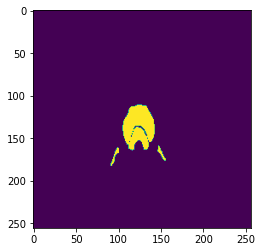

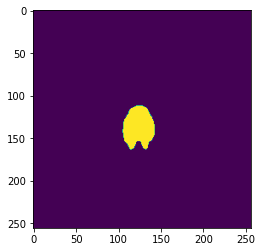

Labelnumber [2], Epoch [420/500], Step [3/8], Loss: 5.5990,---------------------------------- Accuracy: 99.89%
Labelnumber [2], Epoch [420/500], Step [4/8], Loss: 6.4910,---------------------------------- Accuracy: 99.88%
Labelnumber [2], Epoch [420/500], Step [5/8], Loss: 4.9278,---------------------------------- Accuracy: 99.88%
Labelnumber [2], Epoch [420/500], Step [6/8], Loss: 4.7099,---------------------------------- Accuracy: 99.87%
Labelnumber [2], Epoch [420/500], Step [7/8], Loss: 7.3020,---------------------------------- Accuracy: 99.81%
Labelnumber [2], Epoch [420/500], Step [8/8], Loss: 6.7412,---------------------------------- Accuracy: 99.83%
Labelnumber [2], Epoch [421/500], Step [1/8], Loss: 4.8997,---------------------------------- Accuracy: 99.88%
Labelnumber [2], Epoch [421/500], Step [2/8], Loss: 6.7473,---------------------------------- Accuracy: 99.87%
Labelnumber [2], Epoch [421/500], Step [3/8], Loss: 5.7125,---------------------------------- Accuracy: 99.86%
L

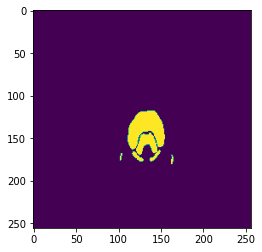

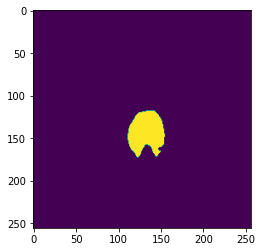

Labelnumber [2], Epoch [430/500], Step [3/8], Loss: 4.7586,---------------------------------- Accuracy: 99.88%
Labelnumber [2], Epoch [430/500], Step [4/8], Loss: 6.1815,---------------------------------- Accuracy: 99.88%
Labelnumber [2], Epoch [430/500], Step [5/8], Loss: 4.3736,---------------------------------- Accuracy: 99.89%
Labelnumber [2], Epoch [430/500], Step [6/8], Loss: 4.6392,---------------------------------- Accuracy: 99.87%
Labelnumber [2], Epoch [430/500], Step [7/8], Loss: 5.5460,---------------------------------- Accuracy: 99.86%
Labelnumber [2], Epoch [430/500], Step [8/8], Loss: 6.5297,---------------------------------- Accuracy: 99.83%
Labelnumber [2], Epoch [431/500], Step [1/8], Loss: 5.7035,---------------------------------- Accuracy: 99.89%
Labelnumber [2], Epoch [431/500], Step [2/8], Loss: 4.9039,---------------------------------- Accuracy: 99.88%
Labelnumber [2], Epoch [431/500], Step [3/8], Loss: 6.3540,---------------------------------- Accuracy: 99.88%
L

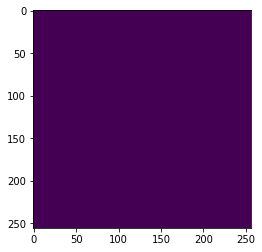

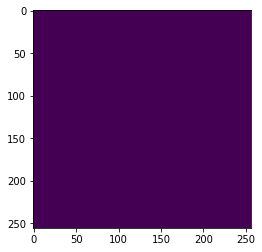

Labelnumber [2], Epoch [440/500], Step [3/8], Loss: 5.3611,---------------------------------- Accuracy: 99.86%
Labelnumber [2], Epoch [440/500], Step [4/8], Loss: 5.9242,---------------------------------- Accuracy: 99.88%
Labelnumber [2], Epoch [440/500], Step [5/8], Loss: 5.1310,---------------------------------- Accuracy: 99.87%
Labelnumber [2], Epoch [440/500], Step [6/8], Loss: 4.8285,---------------------------------- Accuracy: 99.87%
Labelnumber [2], Epoch [440/500], Step [7/8], Loss: 7.1658,---------------------------------- Accuracy: 99.86%
Labelnumber [2], Epoch [440/500], Step [8/8], Loss: 5.2285,---------------------------------- Accuracy: 99.87%
Labelnumber [2], Epoch [441/500], Step [1/8], Loss: 5.5549,---------------------------------- Accuracy: 99.86%
Labelnumber [2], Epoch [441/500], Step [2/8], Loss: 6.3141,---------------------------------- Accuracy: 99.84%
Labelnumber [2], Epoch [441/500], Step [3/8], Loss: 4.6439,---------------------------------- Accuracy: 99.87%
L

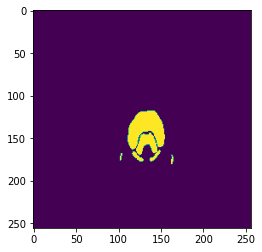

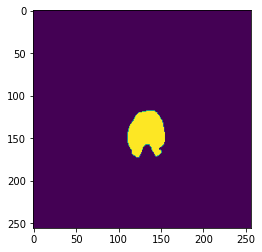

Labelnumber [2], Epoch [450/500], Step [3/8], Loss: 4.0846,---------------------------------- Accuracy: 99.90%
Labelnumber [2], Epoch [450/500], Step [4/8], Loss: 5.1008,---------------------------------- Accuracy: 99.90%
Labelnumber [2], Epoch [450/500], Step [5/8], Loss: 4.5240,---------------------------------- Accuracy: 99.87%
Labelnumber [2], Epoch [450/500], Step [6/8], Loss: 4.6990,---------------------------------- Accuracy: 99.88%
Labelnumber [2], Epoch [450/500], Step [7/8], Loss: 7.3314,---------------------------------- Accuracy: 99.86%
Labelnumber [2], Epoch [450/500], Step [8/8], Loss: 5.0944,---------------------------------- Accuracy: 99.87%
Labelnumber [2], Epoch [451/500], Step [1/8], Loss: 4.9009,---------------------------------- Accuracy: 99.90%
Labelnumber [2], Epoch [451/500], Step [2/8], Loss: 4.4796,---------------------------------- Accuracy: 99.89%
Labelnumber [2], Epoch [451/500], Step [3/8], Loss: 4.0196,---------------------------------- Accuracy: 99.90%
L

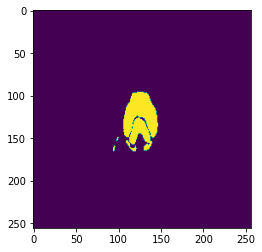

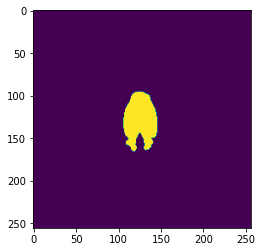

Labelnumber [2], Epoch [460/500], Step [3/8], Loss: 5.1196,---------------------------------- Accuracy: 99.90%
Labelnumber [2], Epoch [460/500], Step [4/8], Loss: 4.4746,---------------------------------- Accuracy: 99.88%
Labelnumber [2], Epoch [460/500], Step [5/8], Loss: 4.9237,---------------------------------- Accuracy: 99.90%
Labelnumber [2], Epoch [460/500], Step [6/8], Loss: 5.1235,---------------------------------- Accuracy: 99.87%
Labelnumber [2], Epoch [460/500], Step [7/8], Loss: 6.1060,---------------------------------- Accuracy: 99.89%
Labelnumber [2], Epoch [460/500], Step [8/8], Loss: 4.1294,---------------------------------- Accuracy: 99.89%
Labelnumber [2], Epoch [461/500], Step [1/8], Loss: 4.5705,---------------------------------- Accuracy: 99.87%
Labelnumber [2], Epoch [461/500], Step [2/8], Loss: 5.4321,---------------------------------- Accuracy: 99.88%
Labelnumber [2], Epoch [461/500], Step [3/8], Loss: 4.1995,---------------------------------- Accuracy: 99.89%
L

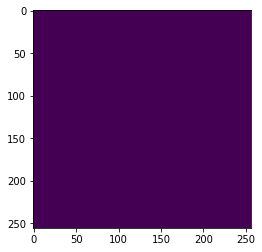

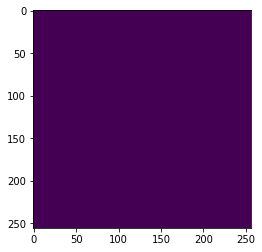

Labelnumber [2], Epoch [470/500], Step [3/8], Loss: 4.0725,---------------------------------- Accuracy: 99.88%
Labelnumber [2], Epoch [470/500], Step [4/8], Loss: 4.8488,---------------------------------- Accuracy: 99.87%
Labelnumber [2], Epoch [470/500], Step [5/8], Loss: 5.7955,---------------------------------- Accuracy: 99.85%
Labelnumber [2], Epoch [470/500], Step [6/8], Loss: 5.0722,---------------------------------- Accuracy: 99.90%
Labelnumber [2], Epoch [470/500], Step [7/8], Loss: 4.5517,---------------------------------- Accuracy: 99.90%
Labelnumber [2], Epoch [470/500], Step [8/8], Loss: 4.2012,---------------------------------- Accuracy: 99.89%
Labelnumber [2], Epoch [471/500], Step [1/8], Loss: 3.9529,---------------------------------- Accuracy: 99.89%
Labelnumber [2], Epoch [471/500], Step [2/8], Loss: 5.3536,---------------------------------- Accuracy: 99.88%
Labelnumber [2], Epoch [471/500], Step [3/8], Loss: 5.0093,---------------------------------- Accuracy: 99.86%
L

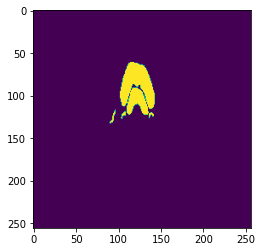

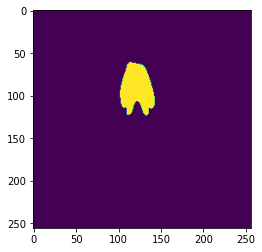

Labelnumber [2], Epoch [480/500], Step [3/8], Loss: 4.5143,---------------------------------- Accuracy: 99.89%
Labelnumber [2], Epoch [480/500], Step [4/8], Loss: 6.6603,---------------------------------- Accuracy: 99.86%
Labelnumber [2], Epoch [480/500], Step [5/8], Loss: 4.2607,---------------------------------- Accuracy: 99.87%
Labelnumber [2], Epoch [480/500], Step [6/8], Loss: 5.4562,---------------------------------- Accuracy: 99.89%
Labelnumber [2], Epoch [480/500], Step [7/8], Loss: 4.1344,---------------------------------- Accuracy: 99.89%
Labelnumber [2], Epoch [480/500], Step [8/8], Loss: 4.3605,---------------------------------- Accuracy: 99.88%
Labelnumber [2], Epoch [481/500], Step [1/8], Loss: 4.0939,---------------------------------- Accuracy: 99.89%
Labelnumber [2], Epoch [481/500], Step [2/8], Loss: 5.6727,---------------------------------- Accuracy: 99.89%
Labelnumber [2], Epoch [481/500], Step [3/8], Loss: 4.5095,---------------------------------- Accuracy: 99.89%
L

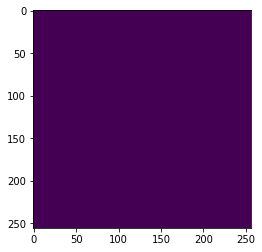

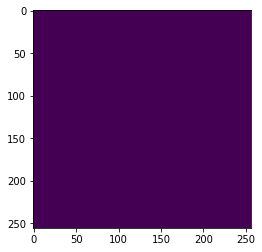

Labelnumber [2], Epoch [490/500], Step [3/8], Loss: 3.8300,---------------------------------- Accuracy: 99.90%
Labelnumber [2], Epoch [490/500], Step [4/8], Loss: 4.5788,---------------------------------- Accuracy: 99.88%
Labelnumber [2], Epoch [490/500], Step [5/8], Loss: 4.0405,---------------------------------- Accuracy: 99.89%
Labelnumber [2], Epoch [490/500], Step [6/8], Loss: 4.5719,---------------------------------- Accuracy: 99.91%
Labelnumber [2], Epoch [490/500], Step [7/8], Loss: 4.2106,---------------------------------- Accuracy: 99.91%
Labelnumber [2], Epoch [490/500], Step [8/8], Loss: 5.2321,---------------------------------- Accuracy: 99.85%
Labelnumber [2], Epoch [491/500], Step [1/8], Loss: 5.3548,---------------------------------- Accuracy: 99.90%
Labelnumber [2], Epoch [491/500], Step [2/8], Loss: 4.0042,---------------------------------- Accuracy: 99.88%
Labelnumber [2], Epoch [491/500], Step [3/8], Loss: 3.7773,---------------------------------- Accuracy: 99.90%
L

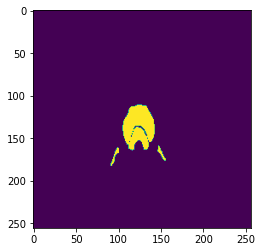

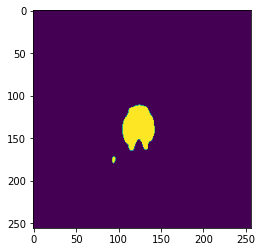

Labelnumber [2], Epoch [500/500], Step [3/8], Loss: 4.3056,---------------------------------- Accuracy: 99.87%
Labelnumber [2], Epoch [500/500], Step [4/8], Loss: 4.3888,---------------------------------- Accuracy: 99.88%
Labelnumber [2], Epoch [500/500], Step [5/8], Loss: 4.5132,---------------------------------- Accuracy: 99.88%
Labelnumber [2], Epoch [500/500], Step [6/8], Loss: 4.6056,---------------------------------- Accuracy: 99.90%
Labelnumber [2], Epoch [500/500], Step [7/8], Loss: 5.3988,---------------------------------- Accuracy: 99.85%
Labelnumber [2], Epoch [500/500], Step [8/8], Loss: 3.8171,---------------------------------- Accuracy: 99.90%
Labelnumber [2], Epoch [1/500], Step [1/8], Loss: 76.9841,---------------------------------- Accuracy: 28.93%
Labelnumber [2], Epoch [1/500], Step [2/8], Loss: 73.5692,---------------------------------- Accuracy: 40.34%
Labelnumber [2], Epoch [1/500], Step [3/8], Loss: 85.5575,---------------------------------- Accuracy: 46.04%
Labe

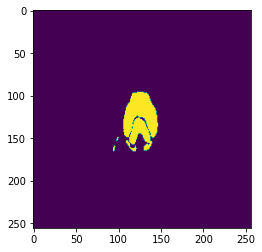

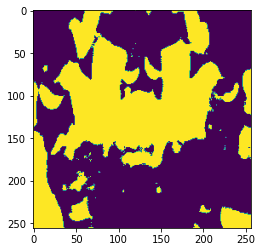

Labelnumber [2], Epoch [10/500], Step [3/8], Loss: 64.0828,---------------------------------- Accuracy: 70.66%
Labelnumber [2], Epoch [10/500], Step [4/8], Loss: 68.1275,---------------------------------- Accuracy: 70.48%
Labelnumber [2], Epoch [10/500], Step [5/8], Loss: 73.4465,---------------------------------- Accuracy: 72.01%
Labelnumber [2], Epoch [10/500], Step [6/8], Loss: 66.7188,---------------------------------- Accuracy: 72.82%
Labelnumber [2], Epoch [10/500], Step [7/8], Loss: 77.1204,---------------------------------- Accuracy: 71.27%
Labelnumber [2], Epoch [10/500], Step [8/8], Loss: 75.3314,---------------------------------- Accuracy: 70.27%
Labelnumber [2], Epoch [11/500], Step [1/8], Loss: 66.3334,---------------------------------- Accuracy: 72.37%
Labelnumber [2], Epoch [11/500], Step [2/8], Loss: 66.5300,---------------------------------- Accuracy: 73.51%
Labelnumber [2], Epoch [11/500], Step [3/8], Loss: 67.9493,---------------------------------- Accuracy: 72.07%
L

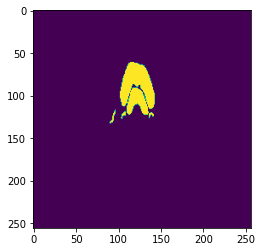

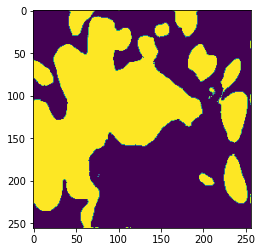

Labelnumber [2], Epoch [20/500], Step [3/8], Loss: 65.4884,---------------------------------- Accuracy: 78.78%
Labelnumber [2], Epoch [20/500], Step [4/8], Loss: 74.5278,---------------------------------- Accuracy: 80.87%
Labelnumber [2], Epoch [20/500], Step [5/8], Loss: 61.5344,---------------------------------- Accuracy: 78.48%
Labelnumber [2], Epoch [20/500], Step [6/8], Loss: 64.0055,---------------------------------- Accuracy: 78.17%
Labelnumber [2], Epoch [20/500], Step [7/8], Loss: 69.7946,---------------------------------- Accuracy: 76.72%
Labelnumber [2], Epoch [20/500], Step [8/8], Loss: 72.6076,---------------------------------- Accuracy: 78.15%
Labelnumber [2], Epoch [21/500], Step [1/8], Loss: 75.3839,---------------------------------- Accuracy: 81.15%
Labelnumber [2], Epoch [21/500], Step [2/8], Loss: 64.0436,---------------------------------- Accuracy: 79.18%
Labelnumber [2], Epoch [21/500], Step [3/8], Loss: 61.8088,---------------------------------- Accuracy: 77.25%
L

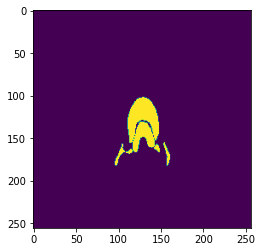

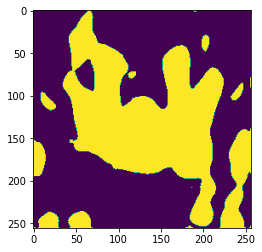

Labelnumber [2], Epoch [30/500], Step [3/8], Loss: 59.9840,---------------------------------- Accuracy: 82.06%
Labelnumber [2], Epoch [30/500], Step [4/8], Loss: 70.7749,---------------------------------- Accuracy: 82.40%
Labelnumber [2], Epoch [30/500], Step [5/8], Loss: 61.9826,---------------------------------- Accuracy: 83.32%
Labelnumber [2], Epoch [30/500], Step [6/8], Loss: 62.4983,---------------------------------- Accuracy: 83.75%
Labelnumber [2], Epoch [30/500], Step [7/8], Loss: 68.1070,---------------------------------- Accuracy: 80.28%
Labelnumber [2], Epoch [30/500], Step [8/8], Loss: 62.2856,---------------------------------- Accuracy: 83.42%
Labelnumber [2], Epoch [31/500], Step [1/8], Loss: 62.2745,---------------------------------- Accuracy: 83.48%
Labelnumber [2], Epoch [31/500], Step [2/8], Loss: 59.9373,---------------------------------- Accuracy: 81.17%
Labelnumber [2], Epoch [31/500], Step [3/8], Loss: 61.8721,---------------------------------- Accuracy: 82.77%
L

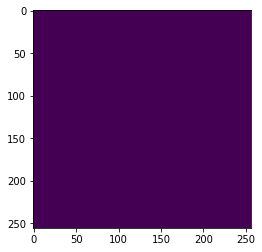

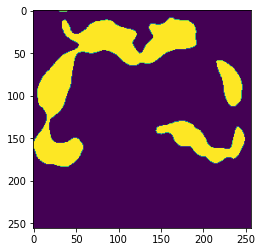

Labelnumber [2], Epoch [40/500], Step [3/8], Loss: 61.0192,---------------------------------- Accuracy: 84.96%
Labelnumber [2], Epoch [40/500], Step [4/8], Loss: 62.5700,---------------------------------- Accuracy: 85.17%
Labelnumber [2], Epoch [40/500], Step [5/8], Loss: 66.5692,---------------------------------- Accuracy: 84.42%
Labelnumber [2], Epoch [40/500], Step [6/8], Loss: 58.7419,---------------------------------- Accuracy: 84.74%
Labelnumber [2], Epoch [40/500], Step [7/8], Loss: 61.2173,---------------------------------- Accuracy: 84.74%
Labelnumber [2], Epoch [40/500], Step [8/8], Loss: 69.5150,---------------------------------- Accuracy: 82.77%
Labelnumber [2], Epoch [41/500], Step [1/8], Loss: 69.2841,---------------------------------- Accuracy: 84.48%
Labelnumber [2], Epoch [41/500], Step [2/8], Loss: 71.2278,---------------------------------- Accuracy: 86.21%
Labelnumber [2], Epoch [41/500], Step [3/8], Loss: 60.7874,---------------------------------- Accuracy: 85.23%
L

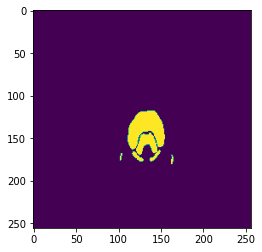

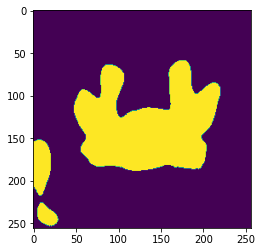

Labelnumber [2], Epoch [50/500], Step [3/8], Loss: 67.9991,---------------------------------- Accuracy: 85.94%
Labelnumber [2], Epoch [50/500], Step [4/8], Loss: 57.3767,---------------------------------- Accuracy: 86.71%
Labelnumber [2], Epoch [50/500], Step [5/8], Loss: 59.7203,---------------------------------- Accuracy: 85.83%
Labelnumber [2], Epoch [50/500], Step [6/8], Loss: 69.8629,---------------------------------- Accuracy: 85.41%
Labelnumber [2], Epoch [50/500], Step [7/8], Loss: 59.4793,---------------------------------- Accuracy: 86.92%
Labelnumber [2], Epoch [50/500], Step [8/8], Loss: 61.1548,---------------------------------- Accuracy: 87.29%
Labelnumber [2], Epoch [51/500], Step [1/8], Loss: 67.9288,---------------------------------- Accuracy: 86.86%
Labelnumber [2], Epoch [51/500], Step [2/8], Loss: 59.2964,---------------------------------- Accuracy: 87.12%
Labelnumber [2], Epoch [51/500], Step [3/8], Loss: 57.3506,---------------------------------- Accuracy: 85.90%
L

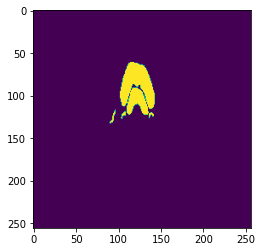

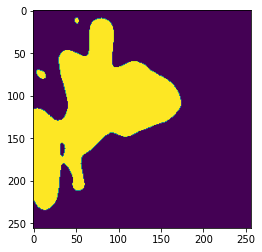

Labelnumber [2], Epoch [60/500], Step [3/8], Loss: 60.1074,---------------------------------- Accuracy: 88.33%
Labelnumber [2], Epoch [60/500], Step [4/8], Loss: 58.3958,---------------------------------- Accuracy: 88.15%
Labelnumber [2], Epoch [60/500], Step [5/8], Loss: 68.5064,---------------------------------- Accuracy: 87.91%
Labelnumber [2], Epoch [60/500], Step [6/8], Loss: 63.9054,---------------------------------- Accuracy: 88.01%
Labelnumber [2], Epoch [60/500], Step [7/8], Loss: 56.5051,---------------------------------- Accuracy: 88.02%
Labelnumber [2], Epoch [60/500], Step [8/8], Loss: 58.5771,---------------------------------- Accuracy: 87.68%
Labelnumber [2], Epoch [61/500], Step [1/8], Loss: 58.3763,---------------------------------- Accuracy: 87.29%
Labelnumber [2], Epoch [61/500], Step [2/8], Loss: 56.3272,---------------------------------- Accuracy: 87.47%
Labelnumber [2], Epoch [61/500], Step [3/8], Loss: 58.5436,---------------------------------- Accuracy: 87.29%
L

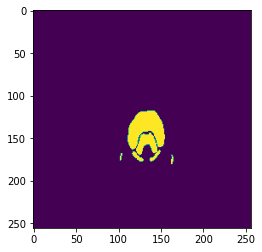

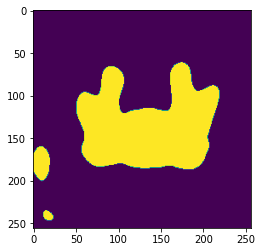

Labelnumber [2], Epoch [70/500], Step [3/8], Loss: 65.9088,---------------------------------- Accuracy: 88.47%
Labelnumber [2], Epoch [70/500], Step [4/8], Loss: 55.6457,---------------------------------- Accuracy: 88.30%
Labelnumber [2], Epoch [70/500], Step [5/8], Loss: 58.0792,---------------------------------- Accuracy: 88.64%
Labelnumber [2], Epoch [70/500], Step [6/8], Loss: 67.5224,---------------------------------- Accuracy: 87.98%
Labelnumber [2], Epoch [70/500], Step [7/8], Loss: 57.5331,---------------------------------- Accuracy: 88.80%
Labelnumber [2], Epoch [70/500], Step [8/8], Loss: 59.2020,---------------------------------- Accuracy: 89.34%
Labelnumber [2], Epoch [71/500], Step [1/8], Loss: 57.6439,---------------------------------- Accuracy: 89.12%
Labelnumber [2], Epoch [71/500], Step [2/8], Loss: 57.9317,---------------------------------- Accuracy: 88.72%
Labelnumber [2], Epoch [71/500], Step [3/8], Loss: 55.5986,---------------------------------- Accuracy: 89.79%
L

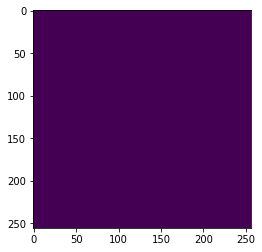

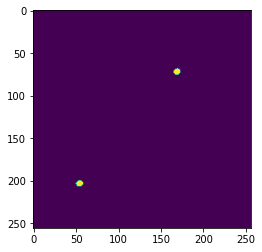

Labelnumber [2], Epoch [80/500], Step [3/8], Loss: 56.6904,---------------------------------- Accuracy: 89.80%
Labelnumber [2], Epoch [80/500], Step [4/8], Loss: 56.3650,---------------------------------- Accuracy: 90.35%
Labelnumber [2], Epoch [80/500], Step [5/8], Loss: 56.9545,---------------------------------- Accuracy: 90.42%
Labelnumber [2], Epoch [80/500], Step [6/8], Loss: 64.8132,---------------------------------- Accuracy: 89.77%
Labelnumber [2], Epoch [80/500], Step [7/8], Loss: 57.9388,---------------------------------- Accuracy: 90.24%
Labelnumber [2], Epoch [80/500], Step [8/8], Loss: 61.8734,---------------------------------- Accuracy: 88.99%
Labelnumber [2], Epoch [81/500], Step [1/8], Loss: 66.4760,---------------------------------- Accuracy: 87.90%
Labelnumber [2], Epoch [81/500], Step [2/8], Loss: 54.3475,---------------------------------- Accuracy: 89.74%
Labelnumber [2], Epoch [81/500], Step [3/8], Loss: 57.7472,---------------------------------- Accuracy: 90.96%
L

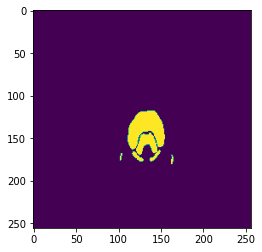

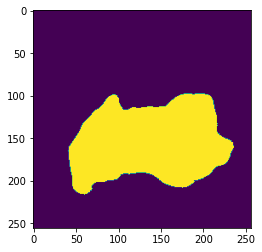

Labelnumber [2], Epoch [90/500], Step [3/8], Loss: 56.9924,---------------------------------- Accuracy: 90.30%
Labelnumber [2], Epoch [90/500], Step [4/8], Loss: 57.9477,---------------------------------- Accuracy: 90.38%
Labelnumber [2], Epoch [90/500], Step [5/8], Loss: 56.6321,---------------------------------- Accuracy: 91.17%
Labelnumber [2], Epoch [90/500], Step [6/8], Loss: 64.4144,---------------------------------- Accuracy: 90.28%
Labelnumber [2], Epoch [90/500], Step [7/8], Loss: 56.7194,---------------------------------- Accuracy: 90.07%
Labelnumber [2], Epoch [90/500], Step [8/8], Loss: 66.1087,---------------------------------- Accuracy: 89.48%
Labelnumber [2], Epoch [91/500], Step [1/8], Loss: 56.5063,---------------------------------- Accuracy: 91.12%
Labelnumber [2], Epoch [91/500], Step [2/8], Loss: 61.3859,---------------------------------- Accuracy: 89.82%
Labelnumber [2], Epoch [91/500], Step [3/8], Loss: 63.9566,---------------------------------- Accuracy: 90.31%
L

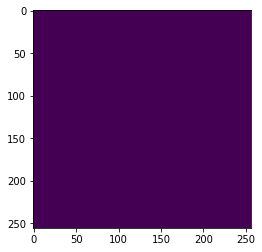

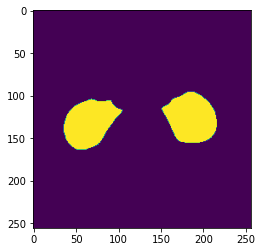

Labelnumber [2], Epoch [100/500], Step [3/8], Loss: 64.5288,---------------------------------- Accuracy: 90.63%
Labelnumber [2], Epoch [100/500], Step [4/8], Loss: 60.0613,---------------------------------- Accuracy: 90.79%
Labelnumber [2], Epoch [100/500], Step [5/8], Loss: 54.8721,---------------------------------- Accuracy: 91.01%
Labelnumber [2], Epoch [100/500], Step [6/8], Loss: 56.3094,---------------------------------- Accuracy: 90.84%
Labelnumber [2], Epoch [100/500], Step [7/8], Loss: 62.7847,---------------------------------- Accuracy: 91.39%
Labelnumber [2], Epoch [100/500], Step [8/8], Loss: 55.3585,---------------------------------- Accuracy: 91.47%
Labelnumber [2], Epoch [101/500], Step [1/8], Loss: 55.1345,---------------------------------- Accuracy: 91.26%
Labelnumber [2], Epoch [101/500], Step [2/8], Loss: 64.8603,---------------------------------- Accuracy: 91.21%
Labelnumber [2], Epoch [101/500], Step [3/8], Loss: 59.9487,---------------------------------- Accuracy:

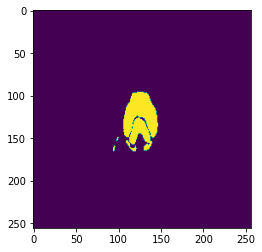

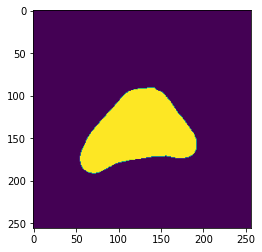

Labelnumber [2], Epoch [110/500], Step [3/8], Loss: 61.6530,---------------------------------- Accuracy: 92.53%
Labelnumber [2], Epoch [110/500], Step [4/8], Loss: 54.3722,---------------------------------- Accuracy: 92.02%
Labelnumber [2], Epoch [110/500], Step [5/8], Loss: 58.9198,---------------------------------- Accuracy: 92.41%
Labelnumber [2], Epoch [110/500], Step [6/8], Loss: 55.1734,---------------------------------- Accuracy: 92.25%
Labelnumber [2], Epoch [110/500], Step [7/8], Loss: 51.7421,---------------------------------- Accuracy: 92.63%
Labelnumber [2], Epoch [110/500], Step [8/8], Loss: 63.3902,---------------------------------- Accuracy: 92.08%
Labelnumber [2], Epoch [111/500], Step [1/8], Loss: 59.5954,---------------------------------- Accuracy: 91.88%
Labelnumber [2], Epoch [111/500], Step [2/8], Loss: 53.8549,---------------------------------- Accuracy: 91.99%
Labelnumber [2], Epoch [111/500], Step [3/8], Loss: 62.1163,---------------------------------- Accuracy:

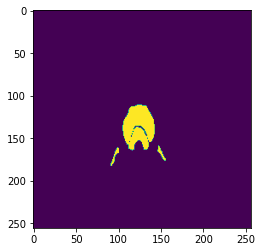

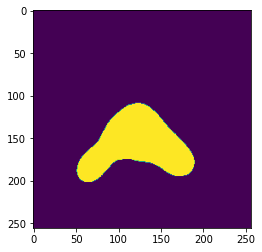

Labelnumber [2], Epoch [120/500], Step [3/8], Loss: 52.8371,---------------------------------- Accuracy: 92.91%
Labelnumber [2], Epoch [120/500], Step [4/8], Loss: 52.9693,---------------------------------- Accuracy: 92.68%
Labelnumber [2], Epoch [120/500], Step [5/8], Loss: 54.2830,---------------------------------- Accuracy: 92.55%
Labelnumber [2], Epoch [120/500], Step [6/8], Loss: 50.8883,---------------------------------- Accuracy: 92.20%
Labelnumber [2], Epoch [120/500], Step [7/8], Loss: 62.2700,---------------------------------- Accuracy: 92.52%
Labelnumber [2], Epoch [120/500], Step [8/8], Loss: 53.3066,---------------------------------- Accuracy: 92.90%
Labelnumber [2], Epoch [121/500], Step [1/8], Loss: 54.2080,---------------------------------- Accuracy: 93.39%
Labelnumber [2], Epoch [121/500], Step [2/8], Loss: 52.8276,---------------------------------- Accuracy: 93.10%
Labelnumber [2], Epoch [121/500], Step [3/8], Loss: 53.1905,---------------------------------- Accuracy:

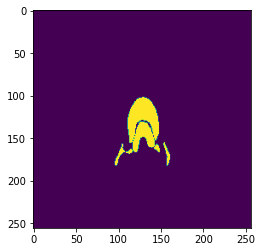

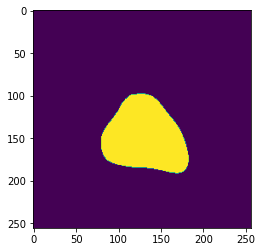

Labelnumber [2], Epoch [130/500], Step [3/8], Loss: 52.2312,---------------------------------- Accuracy: 93.48%
Labelnumber [2], Epoch [130/500], Step [4/8], Loss: 51.8659,---------------------------------- Accuracy: 93.45%
Labelnumber [2], Epoch [130/500], Step [5/8], Loss: 52.5089,---------------------------------- Accuracy: 93.79%
Labelnumber [2], Epoch [130/500], Step [6/8], Loss: 61.3873,---------------------------------- Accuracy: 93.60%
Labelnumber [2], Epoch [130/500], Step [7/8], Loss: 59.6608,---------------------------------- Accuracy: 93.81%
Labelnumber [2], Epoch [130/500], Step [8/8], Loss: 56.9571,---------------------------------- Accuracy: 93.86%
Labelnumber [2], Epoch [131/500], Step [1/8], Loss: 51.7241,---------------------------------- Accuracy: 93.62%
Labelnumber [2], Epoch [131/500], Step [2/8], Loss: 51.8728,---------------------------------- Accuracy: 93.84%
Labelnumber [2], Epoch [131/500], Step [3/8], Loss: 49.8513,---------------------------------- Accuracy:

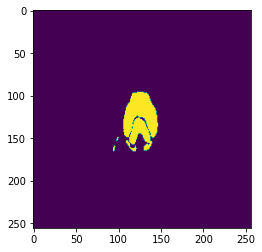

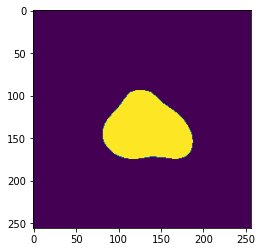

Labelnumber [2], Epoch [140/500], Step [3/8], Loss: 51.4378,---------------------------------- Accuracy: 94.28%
Labelnumber [2], Epoch [140/500], Step [4/8], Loss: 52.2721,---------------------------------- Accuracy: 94.31%
Labelnumber [2], Epoch [140/500], Step [5/8], Loss: 58.9648,---------------------------------- Accuracy: 94.18%
Labelnumber [2], Epoch [140/500], Step [6/8], Loss: 50.8996,---------------------------------- Accuracy: 94.43%
Labelnumber [2], Epoch [140/500], Step [7/8], Loss: 49.0218,---------------------------------- Accuracy: 94.51%
Labelnumber [2], Epoch [140/500], Step [8/8], Loss: 60.3722,---------------------------------- Accuracy: 94.13%
Labelnumber [2], Epoch [141/500], Step [1/8], Loss: 51.2928,---------------------------------- Accuracy: 93.84%
Labelnumber [2], Epoch [141/500], Step [2/8], Loss: 51.0209,---------------------------------- Accuracy: 94.41%
Labelnumber [2], Epoch [141/500], Step [3/8], Loss: 60.1273,---------------------------------- Accuracy:

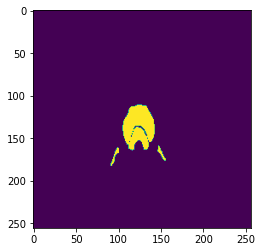

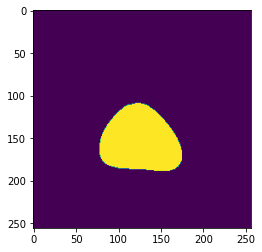

Labelnumber [2], Epoch [150/500], Step [3/8], Loss: 54.9602,---------------------------------- Accuracy: 95.25%
Labelnumber [2], Epoch [150/500], Step [4/8], Loss: 59.2116,---------------------------------- Accuracy: 94.93%
Labelnumber [2], Epoch [150/500], Step [5/8], Loss: 49.8709,---------------------------------- Accuracy: 94.99%
Labelnumber [2], Epoch [150/500], Step [6/8], Loss: 50.3036,---------------------------------- Accuracy: 95.05%
Labelnumber [2], Epoch [150/500], Step [7/8], Loss: 47.9773,---------------------------------- Accuracy: 94.95%
Labelnumber [2], Epoch [150/500], Step [8/8], Loss: 51.1322,---------------------------------- Accuracy: 94.99%
Labelnumber [2], Epoch [151/500], Step [1/8], Loss: 49.7962,---------------------------------- Accuracy: 94.77%
Labelnumber [2], Epoch [151/500], Step [2/8], Loss: 51.2643,---------------------------------- Accuracy: 94.91%
Labelnumber [2], Epoch [151/500], Step [3/8], Loss: 49.6571,---------------------------------- Accuracy:

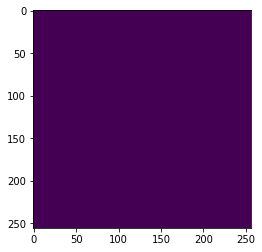

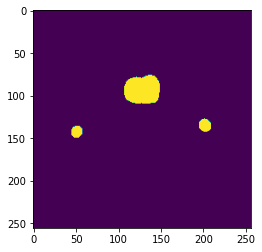

Labelnumber [2], Epoch [160/500], Step [3/8], Loss: 58.1159,---------------------------------- Accuracy: 95.54%
Labelnumber [2], Epoch [160/500], Step [4/8], Loss: 49.0890,---------------------------------- Accuracy: 95.01%
Labelnumber [2], Epoch [160/500], Step [5/8], Loss: 54.0372,---------------------------------- Accuracy: 95.40%
Labelnumber [2], Epoch [160/500], Step [6/8], Loss: 50.2523,---------------------------------- Accuracy: 95.46%
Labelnumber [2], Epoch [160/500], Step [7/8], Loss: 56.9908,---------------------------------- Accuracy: 95.20%
Labelnumber [2], Epoch [160/500], Step [8/8], Loss: 50.0369,---------------------------------- Accuracy: 95.01%
Labelnumber [2], Epoch [161/500], Step [1/8], Loss: 49.2328,---------------------------------- Accuracy: 94.22%
Labelnumber [2], Epoch [161/500], Step [2/8], Loss: 57.1586,---------------------------------- Accuracy: 94.48%
Labelnumber [2], Epoch [161/500], Step [3/8], Loss: 58.2002,---------------------------------- Accuracy:

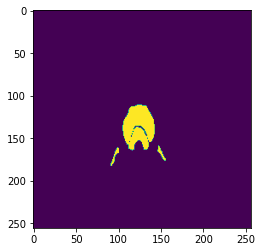

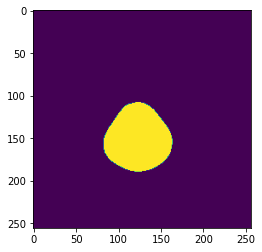

Labelnumber [2], Epoch [170/500], Step [3/8], Loss: 47.6682,---------------------------------- Accuracy: 96.13%
Labelnumber [2], Epoch [170/500], Step [4/8], Loss: 48.1524,---------------------------------- Accuracy: 96.38%
Labelnumber [2], Epoch [170/500], Step [5/8], Loss: 48.1024,---------------------------------- Accuracy: 96.34%
Labelnumber [2], Epoch [170/500], Step [6/8], Loss: 49.0579,---------------------------------- Accuracy: 96.30%
Labelnumber [2], Epoch [170/500], Step [7/8], Loss: 52.6638,---------------------------------- Accuracy: 96.32%
Labelnumber [2], Epoch [170/500], Step [8/8], Loss: 57.3977,---------------------------------- Accuracy: 96.37%
Labelnumber [2], Epoch [171/500], Step [1/8], Loss: 56.7111,---------------------------------- Accuracy: 95.86%
Labelnumber [2], Epoch [171/500], Step [2/8], Loss: 55.4327,---------------------------------- Accuracy: 95.60%
Labelnumber [2], Epoch [171/500], Step [3/8], Loss: 52.5926,---------------------------------- Accuracy:

In [ ]:
# BeeBrain Dataset and Dataloader
import matplotlib.pyplot as plt

#train_dataset = BeeDataset(train_data_path, img_transforms)
for labelnumber in range(1,10):
    labelnumber = 2
    model = UNet()

    if torch.cuda.is_available():
        device = torch.device("cuda") 
        torch.cuda.init()
    else:
        device = torch.device("cpu")
    #device = torch.device("cpu")
    model.to(device)

    ## Dataset und Loader
    train_dataset = BeeDataset_2class(train_data_path, img_transforms, labelclass = labelnumber)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle = True, num_workers = 2)
    ##


    ## weightberechnung außerhalb der loop geht nicht, weil die labels noch nicht geladen
    #backgroundweight =1/(len(label[labels==0])) # 1/(backgroundpixel)
    #classweight = 1/(len(label[labels==labelnumber]))  # 1/(classpixel)
    ##

    ## Loss and optimizer
    #criterion = nn.CrossEntropyLoss(weight = torch.tensor([1,10000], dtype = torch.float).cuda()) # 1/class_size is a typical choice for weight
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.1)
    ##


    # Train the model
    total_step = len(train_loader) # OPTIONAL
    # loss_list to plot our progress
    loss_list = [] # OPTIONAL
    # acc list to plot our accuracy
    acc_list = [] # OPTIONAL
    for epoch in range(num_epochs):
        # goes through train loader -> gives back images and labels
        for i, (images, labels) in enumerate(train_loader):

            ## Weight Berechnung für jedes Bild (Lossfunction muss auch jedes mal neu geladen werden aber macht kaum was aus)
            backgroundweight =1/(len(labels[labels==0])) # 1/(backgroundpixel) # alles außer die klasse als background
            classweight = 1/(len(labels[labels!=0]))  # 1/(classpixel) # die klasse
            labels[labels!=0] = 1
            
            # Loss and optimizer
            #criterion = nn.CrossEntropyLoss(weight = torch.tensor([backgroundweight,classweight], dtype = torch.float).cuda()) # 1/class_size is a typical choice for weight
            criterion = DiceLoss(weight=torch.tensor((1/backgroundweight)/(1/classweight)))
            ##

            labels = labels.to(device, dtype = torch.long)
            images = images.to(device)#.half() # half for 16 bit in 16 bit model
            # images go through forward of model
            
            outputs = model(images)
            _, predicted = torch.max(input = outputs.data, dim = 1)

            # model output and labels go through Loss function
            #outputs = outputs.float() ## required back to 32bit for loss?
            loss = criterion(outputs, labels) 
            #loss = dice_loss(outputs,labels)
            # add result to loss list
            loss_list.append(loss.item())  # OPTIONAL for training, only for plotting
            
            # Backprop and perform Adam optimisation
            
            # gradients are zeroed with zero_grad - what gradients? why zeroed?
            # back propagation on calculated loss
            optimizer.zero_grad()

            loss.backward()
            # optimizer is used -> does it know automatically what to optimize? which data to use? weights in model.parameters!
            optimizer.step()

            ## ACCURACY ONLY FOR TRACKING -> essentially OPTIONAL for training
            
            # Track the accuracy ( number of correctly predicted / number of inputs = batch size)
            # total number of outputs 100 because batch size is 100
            total = labels.size(0)
            # outputs are 10 numbers 0-9 each representing 1 digit, max takes the most probably calculated
            # _ = values which is the number probability 0.25 for 25% , predicted = indices which are 
            # the most probable numbers ( with 10 outputs, the indices are exactly 0-9)
            #_, predicted = torch.max(input = outputs.data, dim = 1)#[0,0,:,:,:]
            predicted = predicted[0,:,:,:]
            
            ## calculates, how many numbers are correct. output is tensor, item() converts it to int/float
            gesamt = len(predicted.flatten())
            correct = len(predicted.flatten()[(predicted.flatten().cpu() == labels.flatten().cpu())])
            accuracy = correct/gesamt*100
            ##

            ##alternative accuracy (nur accuracy von der labelclass)
            #gesamt = len(labels[labels==labelnumber])
            #correct = len(predicted.flatten()[(predicted[labels==labelnumber].flatten().cpu() == labels[labels==labelnumber].flatten().cpu())])
            #accuracy = correct/gesamt*100
            ##

            #correct = (predicted == labels).sum().item()
            # appends to acc list the number of correct ones / total ones == accuracy in %
            acc_list.append(correct / total)

            # PRINTOUT -> optional
            
            ## macht die ausgabe jeden 100sten schritt (wenn der rest von step+1 / 100 = 0 ist)
            if (i + 1) % 1 == 0:
                ## in the {} werden die argumente von .format eingefügt. ":.2f" gibt die zahl der nachkommerstellen an
                print('Labelnumber [{}], Epoch [{}/{}], Step [{}/{}], Loss: {:.4f},---------------------------------- Accuracy: {:.2f}%'
                    .format(labelnumber, epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                            accuracy))
            ## 

            ##Zwischenspeicherung des models alle 100 epochen
            if ((epoch+1) % 100 == 0) and i ==1:
                print("saving model")
                torch.save(model.state_dict(), "/content/drive/My Drive/BeeBrain/BeeBrain_model7von8_labelnumber_"+str(labelnumber)+".ckpt")
            ##

            ##Zwischenstand plotten alle 10 Epochen
            if ((epoch+1) % 10 == 0) and i ==1:
                print("--- Zwischenstand ---")
                plt.imshow(labels.cpu()[0,:,:,:][24])
                plt.show()
                plt.imshow(predicted.cpu()[24])
                plt.show()
                
    torch.save(model.state_dict(), "/content/drive/My Drive/BeeBrain/BeeBrain_model7von8_labelnumber_"+str(labelnumber)+".ckpt")

In [ ]:
torch.save(model.state_dict(), "/content/drive/My Drive/BeeBrain/BeeBrain_model7von8_labelnumber_"+str(labelnumber)+".ckpt")

In [ ]:
labels.unique()

In [ ]:
# accuracy -> flatten output und labels -> zähle richtige -> richtige/gesamt*100
# prediction sollte aus 0/1 bestehen -> nehme nur 1 values und ersetze die entsprechenden im gesamtbild
# predicted[predicted==1]
# predictedgesamt[idx] = predictedmodel[predictedmodel==1]

In [ ]:
### Test Model ###

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import torch
from collections import OrderedDict
import numpy as np
import torch.nn as nn
from math import floor
import matplotlib.pyplot as plt

from skimage import io
#for i in range(0,10):
i = 1
model = UNet().to("cuda")
model.load_state_dict(torch.load("/content/drive/My Drive/BeeBrain/BeeBrain_model7von8_labelnumber_"+str(i)+".ckpt"))
model.eval()
#model = torch.load("/content/drive/My Drive/BeeBrain/BeeBrain_model7von8_labelnumber_"+str(i)+".ckpt")
#model.eval()
#print(model)
image = io.imread(("/content/drive/My Drive/BeeBrain/tiny_testTr/tiny_120920176.tif"))
label = io.imread(("/content/drive/My Drive/BeeBrain/tiny_testTr/new_tiny_label120920176.tif"))
#image = io.imread(("/content/drive/My Drive/BeeBrain/tiny_imagesTr/tiny_060920171.tif"))
#label = io.imread(("/content/drive/My Drive/BeeBrain/tiny_labelsTr/new/new_tiny_label060920171.tif"))

image = np.reshape(image, (1,1,image.shape[0],image.shape[1],image.shape[2]))
image = torch.tensor(image, dtype =torch.float).to("cuda")
output = model(image)
label = torch.tensor(label)
print(np.unique(label))
_, predicted = torch.max(input = output.data, dim = 1) # nimm für jeden wert die höhere wahrscheinlichkeit
predicted = predicted[0,:,:,:] # erste leere dimension rausnehmen der einfacherhalber
pred = np.array(predicted.cpu()) # als np auf cpu fürs plotten

# zum maskieren für jede maske
predlabel = torch.tensor(np.zeros((64,256,256)), device="cuda") # leeren tensor erstellen um masken darauf anzuwenden
correct = (predicted == label.to("cuda")).sum().item()  # die predictions rausnehmen -> besser mit sigmoid später
print(label.shape)
print(predicted.shape)
print(predicted.unique())
predlabel[(predicted==0)] = 10 ## allen werten wo in predicted = 0 ist, einen wert zuweisen ( maskieren)

# accuracy richtig berechnen
gesamt = len(predicted.flatten())
correct = len(predicted.flatten()[(predicted.flatten().cpu() == label.flatten().cpu())])
accuracy = correct/gesamt*100
print(accuracy)

[0 1 2 3 4 5 6 7 8 9]
torch.Size([64, 256, 256])
torch.Size([64, 256, 256])
tensor([0, 1], device='cuda:0')
0.39005279541015625


In [ ]:
predlabel.unique()

tensor([ 0., 10.], device='cuda:0', dtype=torch.float64)

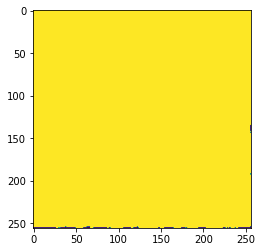

In [ ]:
 # the most probable numbers ( with 10 outputs, the indices are exactly 0-9)
# calculates, how many numbers are correct. output is tensor, item() converts it to int/float
#correct = (predicted == labels).sum().item()
frame = 26
plt.imshow(pred[frame,:,:])

torch.Size([64, 256, 256])

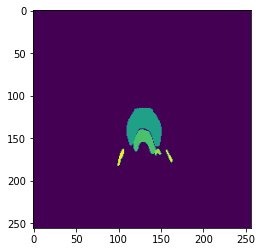

In [ ]:

plt.imshow(label[frame])
label.shape

In [ ]:
# verhaltnis berechnen für weights
a= 1/((len(label[label==1]))/len(label.flatten()))
b = 1/(1-(len(label[label==1]))/len(label.flatten()))
c = 1/len(label[label==1])
d =1/len(label[label==0])
print(a/b)
print(c/d)

11780.752808988764
11676.103932584268
